# Mask R-CNN - Inspect Training Data

Inspect and visualize data loading and pre-processing code.

In [1]:
import os
import sys
import itertools
import math
import logging
import json
import re
import random
from collections import OrderedDict
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as lines
from matplotlib.patches import Polygon
import skimage.draw

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")
sys.path.append("/user/student.aau.dk/htra19/group660/tests/Mask_RCNN")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.config import Config
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

%matplotlib inline

2022-05-19 09:00:53.543309: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
Using TensorFlow backend.


## Configurations

Run one of the code blocks below to import and load the configurations to use.

In [2]:
class CustomConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "object"
    
    BACKBONE = "resnet101"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 2
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 2  # background + 1 parcel

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    
    # Input image resizing:
    IMAGE_RESIZE_MODE = "square"
    IMAGE_MIN_DIM = 1080
    IMAGE_MAX_DIM = 1920
    
    LEARNING_RATE = 0.00002

    # The strides of each layer of the FPN Pyramid. These values
    # are based on a Resnet101 backbone.
    BACKBONE_STRIDES = [4, 8, 16, 32, 64]
    
    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (32, 64, 128, 256, 512)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 1024
    
    POST_NMS_ROIS_INFERENCE = 2000
    
    MAX_GT_INSTANCES = 150

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 1000

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 200
    
    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.7
    
config = CustomConfig()
config.display()



Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      2
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1920
IMAGE_META_SIZE                15
IMAGE_MIN_DIM                  1080
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1920 1920    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  2e-05
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE        

In [3]:
class CustomDataset(utils.Dataset):

    def load_custom(self, dataset_dir, subset):
        """Load a subset of the Dog-Cat dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        # Add classes. We have only one class to add.
        self.add_class("object", 1, "box")

        self.add_class("object", 2, "bag")

        # Train or validation dataset?
        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)

        # Load annotations
        # VGG Image Annotator saves each image in the form:
        # { 'filename': '28503151_5b5b7ec140_b.jpg',
        #   'regions': {
        #       '0': {
        #           'region_attributes': {},
        #           'shape_attributes': {
        #               'all_points_x': [...],
        #               'all_points_y': [...],
        #               'name': 'polygon'}},
        #       ... more regions ...
        #   },
        #   'size': 100202
        # }
        # We mostly care about the x and y coordinates of each region
        annotations1 = json.load(open(os.path.join(dataset_dir, "annotations.json")))
        # print(annotations1)
        annotations = list(annotations1.values())  # don't need the dict keys

         # The VIA tool saves images in the JSON even if they don't have any
        # annotations. Skip unannotated images.
        annotations = [a for a in annotations if a['regions']]

        
        print(annotations)
        # Add images
        for a in annotations:

            print(a)
            # print(a)
            # Get the x, y coordinaets of points of the polygons that make up
            # the outline of each object instance. There are stores in the
            # shape_attributes (see json format above)
            polygons = [r['shape_attributes'] for r in a['regions']] 
            objects = [s['region_attributes']['name'] for s in a['regions']]
            print("objects:",objects)
            name_dict = {"box": 1,"bag": 2}
            print(name_dict)
            # key = tuple(name_dict)
            num_ids = [name_dict[a] for a in objects]
     
            # num_ids = [int(n['Event']) for n in objects]
            # load_mask() needs the image size to convert polygons to masks.
            # Unfortunately, VIA doesn't include it in JSON, so we must read
            # the image. This is only managable since the dataset is tiny.
            print("numids",num_ids)
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]

            self.add_image(
                "object",  ## for a single class just add the name here
                image_id=a['filename'],  # use file name as a unique image id
                path=image_path,
                width=width, height=height,
                polygons=polygons,
                num_ids=num_ids
                )

    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a Dog-Cat dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "object":
            return super(self.__class__, self).load_mask(image_id)

        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]
        if info["source"] != "object":
            return super(self.__class__, self).load_mask(image_id)
        num_ids = info['num_ids']
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to 1
        	rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])

        	mask[rr, cc, i] = 1

        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        # Map class names to class IDs.
        num_ids = np.array(num_ids, dtype=np.int32)
        return mask, num_ids #np.ones([mask.shape[-1]], dtype=np.int32)

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "object":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)



## Dataset

In [4]:
# Load dataset
dataset = CustomDataset()
#dataset_train.load_custom("/user/student.aau.dk/htra19/group660/tests/dataset_first_test", "train")
dataset.load_custom("/user/student.aau.dk/htra19/group660/tests/dataset_beumer_test", "train")
#dataset_train.load_custom("/user/student.aau.dk/htra19/group660/tests/dataset_final_run", "train")
dataset.prepare()

print("Image Count: {}".format(len(dataset.image_ids)))
print("Class Count: {}".format(dataset.num_classes))
for i, info in enumerate(dataset.class_info):
    print("{:3}. {:50}".format(i, info['name']))

[{'filename': '000.jpeg', 'size': 507954, 'regions': [{'shape_attributes': {'name': 'polygon', 'all_points_x': [878, 870, 766, 754, 757, 774, 811, 827, 836, 839, 846, 883, 939, 948, 957, 962, 962, 960, 950, 931, 879], 'all_points_y': [445, 452, 519, 528, 532, 559, 612, 637, 647, 651, 649, 626, 587, 581, 571, 567, 561, 553, 545, 515, 446]}, 'region_attributes': {'name': 'box'}}], 'file_attributes': {}}, {'filename': '001.jpeg', 'size': 508157, 'regions': [{'shape_attributes': {'name': 'polygon', 'all_points_x': [876, 865, 809, 753, 763, 804, 831, 841, 861, 889, 939, 955, 964, 959, 953, 885, 879], 'all_points_y': [444, 455, 491, 528, 543, 601, 642, 651, 642, 622, 588, 574, 565, 551, 550, 451, 446]}, 'region_attributes': {'name': 'box'}}], 'file_attributes': {}}, {'filename': '004.jpeg', 'size': 507288, 'regions': [{'shape_attributes': {'name': 'polygon', 'all_points_x': [710, 709, 712, 718, 718, 652, 647, 640, 639, 640], 'all_points_y': [453, 466, 520, 604, 618, 622, 597, 541, 492, 456]}

{'filename': '012.jpeg', 'size': 514923, 'regions': [{'shape_attributes': {'name': 'polygon', 'all_points_x': [741, 730, 1027, 1036], 'all_points_y': [516, 644, 664, 538]}, 'region_attributes': {'name': 'box'}}], 'file_attributes': {}}
objects: ['box']
{'box': 1, 'bag': 2}
numids [1]
{'filename': '013.jpeg', 'size': 518337, 'regions': [{'shape_attributes': {'name': 'polygon', 'all_points_x': [884, 780, 897, 1000], 'all_points_y': [301, 580, 623, 346]}, 'region_attributes': {'name': 'box'}}], 'file_attributes': {}}
objects: ['box']
{'box': 1, 'bag': 2}
numids [1]
{'filename': '014.jpeg', 'size': 521087, 'regions': [{'shape_attributes': {'name': 'polygon', 'all_points_x': [936, 877, 875, 967, 1008, 1024, 1046, 1062, 1077, 1087, 1090, 1070, 959, 942], 'all_points_y': [393, 532, 549, 589, 603, 607, 568, 537, 501, 467, 460, 444, 399, 395]}, 'region_attributes': {'name': 'box'}}], 'file_attributes': {}}
objects: ['box']
{'box': 1, 'bag': 2}
numids [1]
{'filename': '015.jpeg', 'size': 506472,

{'filename': '036.jpeg', 'size': 504221, 'regions': [{'shape_attributes': {'name': 'polygon', 'all_points_x': [1050, 993, 904, 899, 897, 896, 895, 892, 892, 908, 966, 1015, 1036, 1044], 'all_points_y': [528, 526, 522, 525, 544, 577, 619, 666, 674, 675, 677, 680, 679, 675]}, 'region_attributes': {'name': 'box'}}], 'file_attributes': {}}
objects: ['box']
{'box': 1, 'bag': 2}
numids [1]
{'filename': '037.jpeg', 'size': 508708, 'regions': [{'shape_attributes': {'name': 'polygon', 'all_points_x': [795, 783, 750, 704, 662, 653, 655, 663, 677, 689, 702, 710, 736, 788, 841, 847], 'all_points_y': [364, 368, 379, 397, 412, 417, 424, 447, 485, 517, 552, 557, 546, 526, 507, 503]}, 'region_attributes': {'name': 'box'}}], 'file_attributes': {}}
objects: ['box']
{'box': 1, 'bag': 2}
numids [1]
{'filename': '038.jpeg', 'size': 505156, 'regions': [{'shape_attributes': {'name': 'polygon', 'all_points_x': [704, 699, 694, 685, 677, 666, 652, 642, 635, 646, 681, 718, 755, 772, 784, 806, 838, 840, 788, 730,

{'filename': '072.jpeg', 'size': 508589, 'regions': [{'shape_attributes': {'name': 'polygon', 'all_points_x': [970, 1002, 725, 695, 698, 710, 967], 'all_points_y': [228, 418, 461, 272, 267, 268, 225]}, 'region_attributes': {'name': 'box'}}], 'file_attributes': {}}
objects: ['box']
{'box': 1, 'bag': 2}
numids [1]
{'filename': '073.jpeg', 'size': 509949, 'regions': [{'shape_attributes': {'name': 'polygon', 'all_points_x': [797, 801, 958, 959, 952, 807, 642], 'all_points_y': [440, 440, 544, 549, 555, 779, 673]}, 'region_attributes': {'name': 'box'}}], 'file_attributes': {}}
objects: ['box']
{'box': 1, 'bag': 2}
numids [1]
{'filename': '074.jpeg', 'size': 511115, 'regions': [{'shape_attributes': {'name': 'polygon', 'all_points_x': [1000, 1037, 1035, 816, 812, 799, 802, 783], 'all_points_y': [289, 395, 398, 471, 464, 424, 421, 361]}, 'region_attributes': {'name': 'box'}}], 'file_attributes': {}}
objects: ['box']
{'box': 1, 'bag': 2}
numids [1]
{'filename': '075.jpeg', 'size': 519030, 'regio

{'filename': '097.jpeg', 'size': 512939, 'regions': [{'shape_attributes': {'name': 'polygon', 'all_points_x': [654, 666, 684, 714, 740, 762, 818, 875, 928, 966, 993, 1014, 1021, 1024, 1024, 1024, 1023, 1022, 1018, 1012, 1010, 992, 968, 923, 886, 841, 813, 793, 789, 778, 753, 683, 669, 654, 644, 642, 644, 651, 651, 653], 'all_points_y': [473, 472, 472, 474, 477, 480, 483, 487, 491, 491, 493, 495, 497, 500, 520, 546, 580, 597, 618, 683, 688, 690, 688, 685, 683, 678, 674, 673, 675, 674, 673, 669, 670, 669, 659, 650, 642, 540, 488, 480]}, 'region_attributes': {'name': 'box'}}], 'file_attributes': {}}
objects: ['box']
{'box': 1, 'bag': 2}
numids [1]
{'filename': '098.jpeg', 'size': 504361, 'regions': [{'shape_attributes': {'name': 'polygon', 'all_points_x': [812, 830, 865, 904, 914, 922, 925, 925, 923, 931, 938, 941, 948, 949, 931, 911, 885, 871, 857, 852, 844, 838, 828, 823], 'all_points_y': [341, 335, 326, 314, 313, 313, 314, 319, 327, 357, 389, 394, 422, 430, 435, 439, 445, 452, 456, 458

{'filename': '120.jpeg', 'size': 510235, 'regions': [{'shape_attributes': {'name': 'polygon', 'all_points_x': [836, 843, 863, 904, 1002, 1004, 977], 'all_points_y': [269, 308, 418, 413, 393, 384, 241]}, 'region_attributes': {'name': 'box'}}], 'file_attributes': {}}
objects: ['box']
{'box': 1, 'bag': 2}
numids [1]
{'filename': '121.jpeg', 'size': 506169, 'regions': [{'shape_attributes': {'name': 'polygon', 'all_points_x': [841, 832, 813, 804, 873, 947, 987], 'all_points_y': [445, 487, 565, 597, 617, 635, 485]}, 'region_attributes': {'name': 'box'}}], 'file_attributes': {}}
objects: ['box']
{'box': 1, 'bag': 2}
numids [1]
{'filename': '124.jpeg', 'size': 511198, 'regions': [{'shape_attributes': {'name': 'polygon', 'all_points_x': [698, 671, 915, 928, 951], 'all_points_y': [544, 775, 800, 800, 572]}, 'region_attributes': {'name': 'box'}}, {'shape_attributes': {'name': 'polygon', 'all_points_x': [732, 854, 902, 907, 733, 729], 'all_points_y': [841, 853, 859, 799, 782, 841]}, 'region_attrib

{'filename': '148.jpeg', 'size': 531687, 'regions': [{'shape_attributes': {'name': 'polygon', 'all_points_x': [964, 869, 899, 1081, 1135, 1166, 1143, 1042, 984, 963], 'all_points_y': [534, 794, 804, 839, 691, 610, 596, 559, 538, 534]}, 'region_attributes': {'name': 'box'}}], 'file_attributes': {}}
objects: ['box']
{'box': 1, 'bag': 2}
numids [1]
{'filename': '149.jpeg', 'size': 529692, 'regions': [{'shape_attributes': {'name': 'polygon', 'all_points_x': [614, 626, 664, 719, 749, 775, 799, 885, 981, 1048, 1042, 1015, 945, 898, 884, 868], 'all_points_y': [529, 554, 603, 664, 697, 721, 727, 659, 568, 502, 478, 447, 371, 316, 303, 306]}, 'region_attributes': {'name': 'box'}}], 'file_attributes': {}}
objects: ['box']
{'box': 1, 'bag': 2}
numids [1]
{'filename': '153.jpeg', 'size': 509322, 'regions': [{'shape_attributes': {'name': 'polygon', 'all_points_x': [698, 720, 723, 740, 759, 778, 801, 816, 822, 834, 839, 864, 875, 895, 919, 930, 934, 919, 911, 866, 831, 803, 778, 736, 715, 704], 'all

{'filename': '163.jpeg', 'size': 500841, 'regions': [{'shape_attributes': {'name': 'polygon', 'all_points_x': [720, 879, 885, 886, 881, 725, 718, 718], 'all_points_y': [441, 436, 440, 501, 507, 510, 506, 453]}, 'region_attributes': {'name': 'box'}}, {'shape_attributes': {'name': 'polygon', 'all_points_x': [717, 875, 880, 880, 878, 718, 714, 714], 'all_points_y': [517, 512, 518, 572, 577, 583, 576, 520]}, 'region_attributes': {'name': 'box'}}], 'file_attributes': {}}
objects: ['box', 'box']
{'box': 1, 'bag': 2}
numids [1, 1]
{'filename': '164.jpeg', 'size': 499741, 'regions': [{'shape_attributes': {'name': 'polygon', 'all_points_x': [750, 812, 817, 818, 824, 760, 757], 'all_points_y': [275, 271, 271, 277, 437, 438, 432]}, 'region_attributes': {'name': 'box'}}, {'shape_attributes': {'name': 'polygon', 'all_points_x': [721, 879, 883, 885, 882, 722, 718, 718], 'all_points_y': [443, 437, 442, 501, 505, 512, 506, 452]}, 'region_attributes': {'name': 'box'}}], 'file_attributes': {}}
objects: 

{'filename': '188.jpeg', 'size': 509279, 'regions': [{'shape_attributes': {'name': 'polygon', 'all_points_x': [692, 811, 818, 813, 767, 654], 'all_points_y': [725, 788, 793, 809, 895, 835]}, 'region_attributes': {'name': 'box'}}, {'shape_attributes': {'name': 'polygon', 'all_points_x': [721, 692, 815, 835, 829], 'all_points_y': [687, 721, 790, 755, 747]}, 'region_attributes': {'name': 'box'}}], 'file_attributes': {}}
objects: ['box', 'box']
{'box': 1, 'bag': 2}
numids [1, 1]
{'filename': '189.jpeg', 'size': 521398, 'regions': [{'shape_attributes': {'name': 'polygon', 'all_points_x': [793, 956, 956, 952, 950, 931, 803], 'all_points_y': [606, 611, 646, 725, 731, 731, 725]}, 'region_attributes': {'name': 'box'}}, {'shape_attributes': {'name': 'polygon', 'all_points_x': [805, 795, 955, 956, 951, 846], 'all_points_y': [569, 603, 610, 574, 572, 568]}, 'region_attributes': {'name': 'box'}}, {'shape_attributes': {'name': 'polygon', 'all_points_x': [851, 875, 884, 900, 911, 935, 969, 994, 1016,

{'filename': '213.jpeg', 'size': 531018, 'regions': [{'shape_attributes': {'name': 'polygon', 'all_points_x': [690, 599, 768, 861], 'all_points_y': [324, 449, 575, 454]}, 'region_attributes': {'name': 'box'}}, {'shape_attributes': {'name': 'polygon', 'all_points_x': [900, 856, 1060, 1102], 'all_points_y': [312, 581, 615, 345]}, 'region_attributes': {'name': 'box'}}], 'file_attributes': {}}
objects: ['box', 'box']
{'box': 1, 'bag': 2}
numids [1, 1]
{'filename': '214.jpeg', 'size': 544306, 'regions': [{'shape_attributes': {'name': 'polygon', 'all_points_x': [538, 625, 748, 794, 798, 816, 846, 852, 833, 733, 652, 579, 572, 567], 'all_points_y': [680, 710, 746, 761, 750, 674, 532, 500, 491, 461, 440, 422, 427, 462]}, 'region_attributes': {'name': 'box'}}], 'file_attributes': {}}
objects: ['box']
{'box': 1, 'bag': 2}
numids [1]
{'filename': '215.jpeg', 'size': 542365, 'regions': [{'shape_attributes': {'name': 'polygon', 'all_points_x': [582, 574, 568, 555, 546, 532, 513, 550, 617, 714, 808,

{'filename': '241.jpeg', 'size': 529252, 'regions': [{'shape_attributes': {'name': 'polygon', 'all_points_x': [638, 585, 752, 801, 801], 'all_points_y': [250, 464, 504, 295, 291]}, 'region_attributes': {'name': 'box'}}, {'shape_attributes': {'name': 'polygon', 'all_points_x': [921, 1092, 1102, 929], 'all_points_y': [416, 406, 646, 652]}, 'region_attributes': {'name': 'box'}}], 'file_attributes': {}}
objects: ['box', 'box']
{'box': 1, 'bag': 2}
numids [1, 1]
{'filename': '242.jpeg', 'size': 526990, 'regions': [{'shape_attributes': {'name': 'polygon', 'all_points_x': [707, 899, 888, 876, 869, 677, 676], 'all_points_y': [301, 323, 423, 524, 589, 566, 561]}, 'region_attributes': {'name': 'box'}}], 'file_attributes': {}}
objects: ['box']
{'box': 1, 'bag': 2}
numids [1]
{'filename': '243.jpeg', 'size': 515859, 'regions': [{'shape_attributes': {'name': 'polygon', 'all_points_x': [676, 887, 921, 919, 690, 687, 683, 682], 'all_points_y': [442, 409, 681, 683, 717, 716, 578, 501]}, 'region_attrib

{'filename': '263.jpeg', 'size': 554799, 'regions': [{'shape_attributes': {'name': 'polygon', 'all_points_x': [645, 624, 599, 653, 700, 827, 859, 903], 'all_points_y': [109, 176, 263, 280, 294, 333, 340, 187]}, 'region_attributes': {'name': 'box'}}, {'shape_attributes': {'name': 'polygon', 'all_points_x': [1106, 1086, 999, 966, 873, 877], 'all_points_y': [431, 506, 491, 487, 478, 400]}, 'region_attributes': {'name': 'box'}}, {'shape_attributes': {'name': 'polygon', 'all_points_x': [1116, 914, 901, 876, 1105, 1110, 1112], 'all_points_y': [225, 199, 284, 400, 431, 361, 301]}, 'region_attributes': {'name': 'box'}}, {'shape_attributes': {'name': 'polygon', 'all_points_x': [645, 705, 785, 726], 'all_points_y': [543, 618, 551, 478]}, 'region_attributes': {'name': 'box'}}, {'shape_attributes': {'name': 'polygon', 'all_points_x': [733, 775, 861, 937, 943, 953, 859, 773, 721], 'all_points_y': [813, 824, 835, 846, 829, 788, 778, 766, 756]}, 'region_attributes': {'name': 'box'}}], 'file_attribute

{'filename': '277.jpeg', 'size': 555119, 'regions': [{'shape_attributes': {'name': 'polygon', 'all_points_x': [611, 781, 906, 818, 755, 735, 733], 'all_points_y': [421, 629, 527, 419, 342, 321, 319]}, 'region_attributes': {'name': 'box'}}, {'shape_attributes': {'name': 'polygon', 'all_points_x': [678, 698, 770, 842, 901, 972, 978, 998, 1005, 990, 956, 876, 799, 765, 756, 689, 678], 'all_points_y': [297, 303, 319, 334, 349, 367, 366, 302, 262, 258, 250, 231, 212, 202, 205, 278, 297]}, 'region_attributes': {'name': 'box'}}, {'shape_attributes': {'name': 'polygon', 'all_points_x': [938, 996, 1100, 1044], 'all_points_y': [379, 563, 532, 346]}, 'region_attributes': {'name': 'box'}}, {'shape_attributes': {'name': 'polygon', 'all_points_x': [1197, 1059, 981, 900, 889, 876, 860, 850, 826, 866, 890, 942, 1007, 1049, 1083, 1137, 1141, 1152, 1160, 1174, 1187, 1204, 1198], 'all_points_y': [839, 903, 936, 979, 945, 902, 816, 749, 700, 698, 693, 672, 648, 631, 615, 598, 621, 656, 698, 750, 802, 828,

{'filename': '291.jpeg', 'size': 571562, 'regions': [{'shape_attributes': {'name': 'polygon', 'all_points_x': [630, 964, 1083, 743], 'all_points_y': [325, 473, 198, 55]}, 'region_attributes': {'name': 'box'}}, {'shape_attributes': {'name': 'polygon', 'all_points_x': [1063, 1001, 1015, 1063, 1088, 1100, 1133, 1158, 1162, 1161, 1159, 1095, 1080, 1065], 'all_points_y': [406, 435, 460, 566, 623, 653, 644, 629, 625, 612, 600, 467, 429, 406]}, 'region_attributes': {'name': 'box'}}, {'shape_attributes': {'name': 'polygon', 'all_points_x': [772, 741, 621, 539, 530, 518, 467, 438, 490, 603, 683, 687], 'all_points_y': [481, 467, 438, 421, 425, 488, 691, 800, 815, 840, 855, 849]}, 'region_attributes': {'name': 'box'}}, {'shape_attributes': {'name': 'polygon', 'all_points_x': [957, 911, 928, 989, 1063, 1105, 1122, 1127, 1145, 1162, 1168, 1167], 'all_points_y': [633, 817, 821, 834, 845, 855, 857, 836, 788, 722, 695, 684]}, 'region_attributes': {'name': 'box'}}], 'file_attributes': {}}
objects: ['bo

{'filename': '304.jpeg', 'size': 540621, 'regions': [{'shape_attributes': {'name': 'polygon', 'all_points_x': [1004, 1034, 1090, 1139, 1159, 1142, 1085, 1051, 1017, 994, 990, 956, 932, 890, 856, 834, 830], 'all_points_y': [259, 299, 381, 450, 481, 495, 534, 559, 583, 599, 600, 552, 513, 456, 406, 374, 370]}, 'region_attributes': {'name': 'box'}}, {'shape_attributes': {'name': 'polygon', 'all_points_x': [823, 864, 990, 945, 861, 826], 'all_points_y': [622, 698, 628, 553, 597, 617]}, 'region_attributes': {'name': 'box'}}, {'shape_attributes': {'name': 'polygon', 'all_points_x': [739, 740, 822, 773, 692, 740], 'all_points_y': [630, 631, 674, 765, 726, 634]}, 'region_attributes': {'name': 'box'}}, {'shape_attributes': {'name': 'polygon', 'all_points_x': [750, 756, 810, 836, 876, 876, 867, 815, 748, 691, 685, 684, 678, 611, 580, 568, 556], 'all_points_y': [267, 277, 366, 413, 481, 484, 490, 516, 557, 591, 593, 596, 586, 475, 425, 404, 382]}, 'region_attributes': {'name': 'box'}}, {'shape_at

{'filename': '316.jpeg', 'size': 544810, 'regions': [{'shape_attributes': {'name': 'polygon', 'all_points_x': [800, 791, 638, 636, 638, 797, 800], 'all_points_y': [176, 170, 171, 196, 444, 446, 426]}, 'region_attributes': {'name': 'box'}}, {'shape_attributes': {'name': 'polygon', 'all_points_x': [967, 828, 820, 824, 843, 866, 902, 906, 911, 925, 960, 1009, 1048, 1098, 1123, 1134, 1133, 1109, 1079, 1056, 1046, 1043], 'all_points_y': [359, 435, 443, 459, 488, 532, 587, 593, 595, 592, 572, 543, 521, 490, 475, 467, 460, 415, 363, 326, 314, 311]}, 'region_attributes': {'name': 'box'}}, {'shape_attributes': {'name': 'polygon', 'all_points_x': [785, 661, 590, 559, 551, 544, 541, 639, 688, 705, 849, 961, 968, 971, 972, 960, 904, 836, 822, 816], 'all_points_y': [497, 571, 611, 629, 635, 638, 639, 822, 907, 902, 815, 749, 746, 741, 733, 707, 621, 514, 488, 480]}, 'region_attributes': {'name': 'box'}}, {'shape_attributes': {'name': 'polygon', 'all_points_x': [1037, 1018, 1014, 1004, 1001, 999, 10

{'filename': '332.jpeg', 'size': 563042, 'regions': [{'shape_attributes': {'name': 'polygon', 'all_points_x': [744, 722, 755, 885, 895, 914], 'all_points_y': [198, 328, 336, 358, 317, 231]}, 'region_attributes': {'name': 'box'}}, {'shape_attributes': {'name': 'polygon', 'all_points_x': [738, 741, 706, 644, 588, 583, 581, 591], 'all_points_y': [360, 500, 507, 509, 515, 508, 392, 384]}, 'region_attributes': {'name': 'box'}}, {'shape_attributes': {'name': 'polygon', 'all_points_x': [921, 906, 860, 839, 775, 673, 575, 548, 546, 552, 571, 594, 609, 619, 632, 680, 730, 850, 903, 918], 'all_points_y': [697, 758, 884, 917, 903, 868, 835, 822, 808, 772, 716, 661, 618, 592, 590, 604, 615, 663, 682, 687]}, 'region_attributes': {'name': 'box'}}, {'shape_attributes': {'name': 'polygon', 'all_points_x': [1061, 991, 995, 1000, 995, 1005, 1051, 1066, 1069, 1072, 1069, 1067, 1068, 1067, 1066], 'all_points_y': [515, 515, 539, 712, 751, 755, 756, 757, 748, 715, 629, 595, 560, 547, 527]}, 'region_attribut

{'filename': '345.jpeg', 'size': 571513, 'regions': [{'shape_attributes': {'name': 'polygon', 'all_points_x': [757, 921, 922, 772], 'all_points_y': [268, 268, 170, 177]}, 'region_attributes': {'name': 'box'}}, {'shape_attributes': {'name': 'polygon', 'all_points_x': [658, 722, 915, 879, 879, 854], 'all_points_y': [885, 980, 846, 792, 782, 747]}, 'region_attributes': {'name': 'box'}}, {'shape_attributes': {'name': 'polygon', 'all_points_x': [705, 807, 829, 839, 875, 942, 1024, 1078, 1084, 1081, 1075, 1044, 1013, 1003, 987, 969, 858, 778], 'all_points_y': [477, 629, 664, 662, 632, 583, 521, 474, 463, 454, 442, 382, 328, 317, 316, 318, 379, 432]}, 'region_attributes': {'name': 'box'}}], 'file_attributes': {}}
objects: ['box', 'box', 'box']
{'box': 1, 'bag': 2}
numids [1, 1, 1]
{'filename': '346.jpeg', 'size': 566989, 'regions': [{'shape_attributes': {'name': 'polygon', 'all_points_x': [857, 810, 592, 614, 619, 646], 'all_points_y': [269, 375, 273, 226, 229, 173]}, 'region_attributes': {'n

{'filename': '356.jpeg', 'size': 562690, 'regions': [{'shape_attributes': {'name': 'polygon', 'all_points_x': [850, 932, 935, 1101, 1027], 'all_points_y': [176, 397, 400, 350, 163]}, 'region_attributes': {'name': 'box'}}, {'shape_attributes': {'name': 'polygon', 'all_points_x': [765, 658, 716, 818], 'all_points_y': [442, 500, 604, 551]}, 'region_attributes': {'name': 'box'}}, {'shape_attributes': {'name': 'polygon', 'all_points_x': [598, 552, 668, 718], 'all_points_y': [526, 576, 690, 639]}, 'region_attributes': {'name': 'box'}}, {'shape_attributes': {'name': 'polygon', 'all_points_x': [1020, 860, 949, 1111], 'all_points_y': [435, 689, 746, 487]}, 'region_attributes': {'name': 'box'}}, {'shape_attributes': {'name': 'polygon', 'all_points_x': [867, 730, 722, 831, 950, 952, 869], 'all_points_y': [466, 701, 714, 736, 525, 513, 459]}, 'region_attributes': {'name': 'box'}}], 'file_attributes': {}}
objects: ['box', 'box', 'box', 'box', 'box']
{'box': 1, 'bag': 2}
numids [1, 1, 1, 1, 1]
{'fil

{'filename': '372.jpeg', 'size': 584975, 'regions': [{'shape_attributes': {'name': 'polygon', 'all_points_x': [1089, 1075, 1066, 1037, 1019, 991, 975, 970, 960, 951, 945, 939, 931, 929, 928, 914, 883, 858, 833, 821, 814, 811, 820, 865, 889, 929, 976, 1013, 1043, 1066, 1074, 1083, 1092, 1104, 1109, 1113, 1117, 1121, 1127, 1128, 1157, 1169, 1176, 1183, 1185, 1179, 1156], 'all_points_y': [167, 157, 151, 130, 114, 93, 82, 79, 72, 67, 65, 63, 63, 63, 64, 76, 100, 120, 141, 151, 161, 165, 170, 206, 225, 252, 291, 321, 341, 357, 359, 366, 374, 377, 375, 369, 361, 351, 350, 350, 304, 288, 274, 261, 250, 242, 220]}, 'region_attributes': {'name': 'box'}}, {'shape_attributes': {'name': 'polygon', 'all_points_x': [997, 1070, 1089, 1095, 1100, 1092, 1085, 1080, 1072, 1064, 1047, 1012, 990, 941, 916, 890, 871, 850, 837, 822, 808, 797, 779, 770, 769, 764, 760, 761, 764, 773, 775, 780, 787], 'all_points_y': [450, 416, 407, 404, 400, 384, 371, 363, 360, 361, 369, 385, 396, 417, 429, 443, 451, 460, 467,

{'filename': '386.jpeg', 'size': 555814, 'regions': [{'shape_attributes': {'name': 'polygon', 'all_points_x': [686, 672, 664, 660, 638, 611, 584, 568, 559, 555, 557, 560, 563, 568, 570, 574, 578, 581, 582, 582, 580, 623, 676, 688], 'all_points_y': [439, 285, 184, 147, 149, 151, 154, 156, 157, 157, 182, 214, 248, 295, 331, 374, 408, 440, 450, 457, 460, 457, 455, 452]}, 'region_attributes': {'name': 'box'}}, {'shape_attributes': {'name': 'polygon', 'all_points_x': [736, 741, 745, 749, 756, 762, 767, 770, 782, 802, 851, 904, 940, 951, 956, 962, 964, 962, 956, 945, 938, 933, 926, 920, 908, 904, 901, 897, 891, 864, 823, 768, 740, 719, 710, 702, 703, 704], 'all_points_y': [506, 527, 543, 559, 590, 607, 620, 623, 625, 621, 609, 597, 590, 585, 584, 580, 570, 560, 526, 487, 457, 434, 405, 379, 323, 305, 292, 288, 289, 293, 301, 316, 321, 326, 333, 342, 360, 377]}, 'region_attributes': {'name': 'box'}}, {'shape_attributes': {'name': 'polygon', 'all_points_x': [990, 1048, 1057, 1050, 1036, 1023, 

{'filename': '399.jpeg', 'size': 552464, 'regions': [{'shape_attributes': {'name': 'polygon', 'all_points_x': [720, 720, 813, 800, 768, 758, 736, 681, 617, 602, 599, 603, 629, 650, 652, 655], 'all_points_y': [371, 370, 322, 295, 235, 217, 228, 259, 292, 300, 301, 312, 358, 397, 403, 406]}, 'region_attributes': {'name': 'box'}}, {'shape_attributes': {'name': 'polygon', 'all_points_x': [917, 892, 884, 878, 865, 830, 816, 813, 785, 752, 735, 729, 731, 754, 796, 817, 822, 841, 881, 941, 963, 966], 'all_points_y': [134, 94, 79, 70, 77, 96, 107, 110, 125, 144, 155, 160, 166, 204, 275, 310, 313, 302, 276, 237, 221, 214]}, 'region_attributes': {'name': 'box'}}, {'shape_attributes': {'name': 'polygon', 'all_points_x': [771, 729, 720, 716, 769, 791, 797, 814, 879, 924, 955, 967, 967, 939, 912, 899, 897, 888], 'all_points_y': [564, 532, 526, 523, 453, 423, 421, 431, 480, 511, 535, 547, 554, 596, 634, 650, 653, 649]}, 'region_attributes': {'name': 'box'}}, {'shape_attributes': {'name': 'polygon', 

{'filename': '412.jpeg', 'size': 534240, 'regions': [{'shape_attributes': {'name': 'polygon', 'all_points_x': [946, 955, 967, 968, 943, 912, 884, 866, 850, 850, 848, 844, 832, 817, 811, 800, 799, 799, 826, 919], 'all_points_y': [429, 394, 344, 341, 332, 323, 316, 312, 309, 313, 322, 341, 387, 443, 468, 505, 510, 512, 519, 542]}, 'region_attributes': {'name': 'box'}}, {'shape_attributes': {'name': 'polygon', 'all_points_x': [729, 799, 807, 809, 800, 798, 751, 698, 651, 621, 617, 625, 632, 659, 715], 'all_points_y': [381, 402, 405, 410, 423, 424, 413, 396, 382, 372, 370, 357, 348, 361, 377]}, 'region_attributes': {'name': 'box'}}, {'shape_attributes': {'name': 'polygon', 'all_points_x': [927, 943, 963, 968, 937, 932, 916, 904, 891, 883, 880, 867, 849, 827, 812, 801, 791, 782, 807, 829], 'all_points_y': [611, 594, 573, 567, 539, 545, 560, 572, 584, 594, 598, 610, 627, 649, 664, 674, 684, 693, 727, 710]}, 'region_attributes': {'name': 'box'}}, {'shape_attributes': {'name': 'polygon', 'all_

{'filename': '429.jpeg', 'size': 555248, 'regions': [{'shape_attributes': {'name': 'polygon', 'all_points_x': [753, 741, 739, 732, 688, 666, 656, 665, 688, 707, 712, 726, 785, 799], 'all_points_y': [229, 218, 217, 229, 280, 312, 325, 334, 353, 367, 372, 364, 288, 268]}, 'region_attributes': {'name': 'box'}}, {'shape_attributes': {'name': 'polygon', 'all_points_x': [538, 598, 660, 691, 693, 685, 678, 672, 665, 663, 620, 558, 529, 483, 472, 456, 450, 453, 457, 464, 473, 475], 'all_points_y': [677, 670, 662, 657, 657, 618, 549, 511, 487, 480, 488, 499, 505, 514, 517, 519, 521, 535, 578, 633, 677, 689]}, 'region_attributes': {'name': 'box'}}, {'shape_attributes': {'name': 'polygon', 'all_points_x': [873, 978, 1060, 1103, 1118, 1118, 1107, 1094, 1091, 1072, 1060, 1027, 1020, 981, 958, 916, 892, 865, 844, 825, 814, 802, 789, 784, 784, 782, 785], 'all_points_y': [622, 605, 595, 590, 589, 580, 562, 555, 551, 552, 554, 553, 555, 561, 564, 570, 570, 575, 580, 581, 583, 586, 588, 590, 601, 625, 6

{'filename': '443.jpeg', 'size': 572288, 'regions': [{'shape_attributes': {'name': 'polygon', 'all_points_x': [677, 657, 655, 689, 720, 727, 728, 734, 738, 741, 744, 746, 746, 744, 744], 'all_points_y': [198, 381, 413, 419, 428, 421, 412, 353, 316, 277, 251, 238, 225, 217, 214]}, 'region_attributes': {'name': 'box'}}, {'shape_attributes': {'name': 'polygon', 'all_points_x': [920, 928, 932, 929, 904, 858, 828, 817, 807, 798, 793, 784, 773, 766, 762, 747, 741, 737, 753, 772, 801, 823, 840, 849, 855, 883], 'all_points_y': [310, 292, 284, 280, 264, 234, 214, 208, 202, 197, 198, 213, 227, 241, 248, 273, 284, 337, 349, 359, 380, 395, 404, 409, 413, 375]}, 'region_attributes': {'name': 'box'}}, {'shape_attributes': {'name': 'polygon', 'all_points_x': [726, 740, 752, 756, 806, 844, 846, 843, 841, 829, 824, 825, 817, 817, 814, 807, 799, 795, 792, 792, 789, 786, 779, 730, 701, 699], 'all_points_y': [565, 517, 474, 464, 478, 491, 492, 501, 505, 552, 566, 572, 598, 600, 602, 628, 652, 666, 675, 68

{'filename': '459.jpeg', 'size': 565744, 'regions': [{'shape_attributes': {'name': 'polygon', 'all_points_x': [592, 644, 662, 667, 737, 781, 810, 785, 734, 718, 701, 603, 570], 'all_points_y': [426, 479, 495, 497, 427, 384, 358, 329, 278, 264, 275, 365, 403]}, 'region_attributes': {'name': 'box'}}, {'shape_attributes': {'name': 'polygon', 'all_points_x': [871, 815, 811, 817, 838, 842, 847, 852, 855, 861, 906, 944, 978, 996, 999, 998, 985, 977, 971, 956], 'all_points_y': [318, 303, 301, 289, 222, 210, 165, 152, 146, 147, 159, 169, 177, 182, 186, 195, 236, 274, 292, 339]}, 'region_attributes': {'name': 'box'}}, {'shape_attributes': {'name': 'polygon', 'all_points_x': [833, 903, 907, 908, 890, 864, 850, 843, 840, 792, 750, 749, 811], 'all_points_y': [608, 552, 550, 548, 522, 490, 475, 470, 470, 509, 543, 547, 623]}, 'region_attributes': {'name': 'box'}}, {'shape_attributes': {'name': 'polygon', 'all_points_x': [1095, 1051, 1008, 969, 937, 926, 926, 924, 918, 914, 911, 909, 913, 1003, 1103

{'filename': '1036.jpeg', 'size': 500302, 'regions': [{'shape_attributes': {'name': 'polygon', 'all_points_x': [761, 642, 638, 699, 699, 704, 703, 833, 839, 839, 834, 777, 771], 'all_points_y': [346, 398, 400, 534, 537, 538, 534, 475, 477, 474, 471, 340, 341]}, 'region_attributes': {'name': 'box'}}], 'file_attributes': {}}
objects: ['box']
{'box': 1, 'bag': 2}
numids [1]
{'filename': '1037.jpeg', 'size': 501744, 'regions': [{'shape_attributes': {'name': 'polygon', 'all_points_x': [754, 775, 778, 920, 922, 927, 927, 924, 904, 903, 900, 899, 849, 795, 766, 757, 755, 754, 754, 756], 'all_points_y': [473, 333, 329, 350, 349, 350, 352, 353, 485, 497, 499, 496, 491, 482, 478, 478, 479, 478, 475, 474]}, 'region_attributes': {'name': 'box'}}, {'shape_attributes': {'name': 'polygon', 'all_points_x': [952, 1084, 1086, 1089, 1123, 1128, 1127, 990, 987, 984, 970, 960, 952, 949, 949], 'all_points_y': [348, 313, 310, 312, 438, 454, 458, 495, 498, 498, 438, 399, 362, 349, 347]}, 'region_attributes': 

{'filename': '1064.jpeg', 'size': 497563, 'regions': [{'shape_attributes': {'name': 'polygon', 'all_points_x': [767, 768, 753, 753, 757, 848, 853, 855, 871, 872, 870, 867, 813, 772, 769], 'all_points_y': [398, 402, 483, 485, 485, 504, 506, 505, 422, 419, 416, 417, 408, 400, 398]}, 'region_attributes': {'name': 'box'}}], 'file_attributes': {}}
objects: ['box']
{'box': 1, 'bag': 2}
numids [1]
{'filename': '1065.jpeg', 'size': 503727, 'regions': [{'shape_attributes': {'name': 'polygon', 'all_points_x': [936, 933, 919, 855, 775, 703, 629, 614, 610, 608, 652, 671, 674, 690, 706, 715, 725, 730, 732, 741, 819, 843, 910, 918, 928, 942, 965, 995, 1064, 1016, 982, 945], 'all_points_y': [282, 286, 293, 322, 361, 396, 430, 436, 437, 442, 534, 573, 578, 612, 647, 665, 686, 697, 699, 694, 658, 646, 613, 608, 605, 598, 587, 572, 540, 438, 363, 285]}, 'region_attributes': {'name': 'box'}}], 'file_attributes': {}}
objects: ['box']
{'box': 1, 'bag': 2}
numids [1]
{'filename': '1066.jpeg', 'size': 499833

{'filename': '1088.jpeg', 'size': 524484, 'regions': [{'shape_attributes': {'name': 'polygon', 'all_points_x': [886, 961, 1013, 1036, 1042, 1043, 1039, 1036, 1028, 1015, 1007, 992, 970, 944, 923, 880, 835, 798, 763, 748, 745, 745, 750, 751, 755, 763, 770, 779, 783, 789, 795, 799, 804, 812, 823, 836, 850], 'all_points_y': [443, 463, 477, 486, 492, 501, 524, 549, 567, 619, 654, 700, 701, 698, 692, 682, 672, 659, 649, 642, 635, 624, 607, 596, 577, 549, 518, 489, 476, 460, 441, 436, 432, 431, 431, 431, 434]}, 'region_attributes': {'name': 'box'}}], 'file_attributes': {}}
objects: ['box']
{'box': 1, 'bag': 2}
numids [1]
{'filename': '1089.jpeg', 'size': 543585, 'regions': [{'shape_attributes': {'name': 'polygon', 'all_points_x': [809, 804, 766, 734, 713, 693, 682, 678, 671, 666, 654, 652, 660, 672, 701, 712, 737, 742, 748, 753, 758, 765, 774, 776, 780, 802, 825, 833, 844, 845, 847, 887, 890, 895, 900, 910, 945, 955, 956, 965, 975, 981, 990, 996, 993, 990, 988, 947, 943, 940, 904, 881, 867, 

{'filename': '1123.jpeg', 'size': 517832, 'regions': [{'shape_attributes': {'name': 'polygon', 'all_points_x': [713, 831, 910, 963, 985, 992, 997, 997, 998, 998, 997, 993, 969, 898, 805, 710, 696, 693, 691, 693, 694, 694, 697, 697, 701, 702], 'all_points_y': [300, 301, 302, 302, 303, 304, 309, 399, 488, 542, 554, 559, 559, 557, 556, 555, 555, 555, 551, 429, 351, 304, 303, 301, 301, 299]}, 'region_attributes': {'name': 'box'}}], 'file_attributes': {}}
objects: ['box']
{'box': 1, 'bag': 2}
numids [1]
{'filename': '1124.jpeg', 'size': 530731, 'regions': [{'shape_attributes': {'name': 'polygon', 'all_points_x': [651, 850, 861, 916, 920, 732, 718, 713, 696, 684, 673], 'all_points_y': [531, 580, 563, 344, 328, 273, 275, 304, 358, 382, 420]}, 'region_attributes': {'name': 'box'}}], 'file_attributes': {}}
objects: ['box']
{'box': 1, 'bag': 2}
numids [1]
{'filename': '1126.jpeg', 'size': 537032, 'regions': [{'shape_attributes': {'name': 'polygon', 'all_points_x': [939, 1046, 1050, 1049, 1038, 1

{'filename': '492.jpeg', 'size': 520434, 'regions': [{'shape_attributes': {'name': 'polygon', 'all_points_x': [748, 746, 747, 750, 749, 751, 751, 753, 753, 754, 755, 753, 754, 756, 754, 755, 755, 755, 759, 760, 763, 768, 769, 775, 779, 787, 795, 796, 800, 805, 811, 816, 821, 826, 830, 850, 855, 860, 867, 878, 885, 890, 905, 910, 918, 926, 929, 934, 943, 946, 951, 953, 945, 946, 955, 957, 960, 963, 965, 965, 963, 962, 965, 969, 971, 972, 973, 973, 975, 976, 979, 980, 979, 979, 981, 983, 980, 980, 982, 985, 988, 990, 988, 977, 972, 960, 955, 953, 944, 903, 844, 832, 823, 812, 803, 794, 790, 778, 765, 757, 744, 741], 'all_points_y': [385, 390, 402, 418, 421, 431, 441, 457, 462, 485, 489, 503, 528, 550, 558, 576, 585, 600, 605, 612, 617, 621, 624, 627, 629, 631, 631, 632, 632, 633, 632, 629, 629, 632, 634, 643, 644, 648, 653, 660, 663, 670, 681, 683, 689, 693, 694, 692, 686, 680, 666, 661, 657, 653, 636, 630, 624, 616, 609, 602, 591, 588, 583, 544, 519, 501, 483, 477, 474, 462, 441, 427, 4

{'filename': '505.jpeg', 'size': 533903, 'regions': [{'shape_attributes': {'name': 'polygon', 'all_points_x': [817, 792, 759, 749, 729, 696, 683, 682, 681, 680, 675, 672, 674, 677, 683, 766, 843, 862, 877, 887, 893, 896, 896, 899, 912, 918, 942, 962, 989, 1014, 1031, 1034, 982, 953, 945, 917, 905, 894], 'all_points_y': [524, 468, 405, 381, 344, 277, 255, 252, 250, 249, 235, 233, 230, 230, 228, 184, 144, 135, 130, 129, 130, 135, 140, 148, 172, 184, 229, 272, 325, 371, 408, 415, 442, 456, 458, 471, 477, 482]}, 'region_attributes': {'name': 'bag'}}], 'file_attributes': {}}
objects: ['bag']
{'box': 1, 'bag': 2}
numids [2]
{'filename': '506.jpeg', 'size': 511717, 'regions': [{'shape_attributes': {'name': 'polygon', 'all_points_x': [807, 822, 843, 865, 876, 886, 894, 896, 898, 902, 904, 904, 914, 922, 931, 934, 941, 944, 945, 945, 948, 950, 953, 956, 957, 957, 960, 959, 957, 948, 942, 937, 934, 927, 921, 918, 905, 892, 883, 875, 870, 858, 850, 848, 844, 835, 825, 821, 819, 818, 817, 814, 808

{'filename': '519.jpeg', 'size': 519897, 'regions': [{'shape_attributes': {'name': 'polygon', 'all_points_x': [770, 766, 776, 795, 813, 824, 839, 849, 860, 883, 894, 912, 927, 932, 949, 973, 979, 981, 987, 996, 1000, 1004, 1009, 1013, 1012, 1010, 997, 985, 980, 977, 971, 959, 956, 952, 948, 942, 937, 929, 925, 924, 922, 919, 918, 916, 904, 899, 894, 887, 885, 881, 879, 870, 869, 867, 865, 863, 862, 860, 851, 837, 836, 827, 820, 811, 804, 799, 796, 791, 787, 776, 764, 743, 732, 721, 711, 706, 702, 693, 690, 686, 681, 677, 675, 673, 672, 670, 671, 671, 673, 676, 677, 678, 682, 686, 688, 687, 693, 694, 698, 700, 702, 703, 705, 702, 707, 718, 720, 723, 724, 727, 727, 733, 744, 752], 'all_points_y': [814, 809, 804, 795, 785, 779, 768, 765, 757, 742, 736, 725, 716, 714, 705, 689, 687, 682, 681, 678, 670, 673, 677, 675, 673, 669, 656, 644, 641, 638, 629, 610, 605, 601, 596, 587, 581, 572, 564, 558, 553, 550, 545, 540, 518, 508, 499, 487, 483, 480, 478, 475, 485, 485, 488, 491, 497, 499, 507, 

{'filename': '532.jpeg', 'size': 526746, 'regions': [{'shape_attributes': {'name': 'polygon', 'all_points_x': [765, 766, 769, 772, 778, 783, 796, 799, 802, 805, 808, 813, 815, 824, 829, 833, 838, 845, 852, 854, 863, 867, 874, 880, 884, 886, 887, 888, 889, 895, 901, 907, 913, 918, 920, 925, 929, 933, 937, 940, 952, 956, 956, 957, 957, 955, 946, 945, 936, 933, 942, 944, 939, 929, 918, 916, 914, 910, 905, 897, 891, 889, 887, 877, 872, 860, 850, 846, 845, 843, 841, 838, 835, 832, 830, 828, 827, 828, 827, 827, 823, 817, 814, 809, 806, 803, 802, 801, 800, 795, 787, 781, 779, 778, 781, 781, 776, 760, 758, 755, 753, 747, 731, 728, 724, 723, 720, 719, 716, 711, 708, 706, 704, 701, 699, 697, 693, 692, 691, 688, 688, 688, 686, 685, 687, 689, 693, 695, 701, 699, 699, 705, 707, 706, 718, 727, 732, 735, 742, 745, 746, 747, 750, 747, 750, 755, 759, 757, 756, 760], 'all_points_y': [629, 630, 630, 628, 627, 627, 611, 607, 603, 601, 599, 598, 594, 587, 584, 581, 581, 580, 577, 576, 570, 569, 565, 561, 5

{'filename': '546.jpeg', 'size': 534766, 'regions': [{'shape_attributes': {'name': 'polygon', 'all_points_x': [537, 542, 543, 545, 545, 553, 571, 586, 617, 657, 706, 756, 802, 842, 870, 898, 906, 918, 913, 907, 902, 901, 896, 895, 891, 888, 887, 883, 879, 877, 871, 867, 865, 864, 856, 852, 850, 843, 832, 821, 807, 794, 786, 782, 780, 771, 770, 765, 761, 755, 752, 746, 740, 730, 726, 722, 720, 719, 716, 711, 708, 704, 698, 691, 680, 669, 661, 655, 650, 639, 630, 627, 621, 605, 600, 592, 589, 581, 571, 565, 547, 539, 522, 513, 508, 503, 504, 510, 514, 517, 517, 518, 516, 528, 531, 534, 540, 548, 550, 551, 550], 'all_points_y': [682, 655, 625, 603, 600, 599, 600, 601, 607, 613, 621, 627, 634, 639, 644, 652, 654, 656, 678, 697, 709, 718, 734, 738, 734, 742, 755, 780, 801, 813, 827, 836, 846, 850, 865, 871, 873, 881, 892, 899, 905, 911, 915, 918, 918, 935, 937, 933, 933, 935, 935, 933, 930, 925, 922, 919, 917, 918, 922, 930, 932, 935, 939, 941, 942, 939, 936, 934, 932, 931, 930, 931, 928, 9

{'filename': '561.jpeg', 'size': 521716, 'regions': [{'shape_attributes': {'name': 'polygon', 'all_points_x': [696, 699, 704, 710, 713, 718, 752, 786, 809, 835, 847, 868, 875, 882, 886, 896, 902, 906, 911, 924, 932, 954, 965, 988, 999, 1001, 1008, 1019, 1026, 1037, 1052, 1055, 1056, 1060, 1066, 1067, 1064, 996, 947, 932, 907, 889, 867, 861, 858, 856, 856, 855, 848, 846, 842, 836, 833, 832, 829, 825, 823, 819, 811, 801, 794, 782, 776, 771, 752, 746, 737, 727, 717], 'all_points_y': [595, 597, 598, 598, 598, 603, 623, 644, 658, 676, 684, 692, 695, 697, 699, 713, 718, 721, 710, 683, 674, 634, 618, 579, 560, 558, 550, 531, 519, 501, 480, 474, 472, 469, 461, 457, 454, 414, 384, 374, 359, 348, 333, 329, 333, 335, 338, 342, 351, 352, 359, 371, 376, 380, 384, 393, 397, 405, 419, 435, 446, 465, 476, 483, 512, 521, 534, 551, 566]}, 'region_attributes': {'name': 'bag'}}], 'file_attributes': {}}
objects: ['bag']
{'box': 1, 'bag': 2}
numids [2]
{'filename': '562.jpeg', 'size': 515044, 'regions': [{'

{'filename': '579.jpeg', 'size': 536252, 'regions': [{'shape_attributes': {'name': 'polygon', 'all_points_x': [719, 728, 736, 750, 782, 828, 842, 853, 860, 879, 915, 950, 955, 956, 956, 953, 953, 952, 951, 950, 950, 953, 954, 952, 951, 952, 950, 949, 949, 950, 951, 951, 950, 948, 949, 950, 950, 947, 945, 937, 899, 817, 747, 726, 712, 709, 707, 707, 709, 714, 715, 716, 716, 718, 721, 721], 'all_points_y': [639, 638, 638, 636, 637, 636, 636, 636, 636, 634, 634, 636, 638, 634, 630, 621, 604, 548, 521, 517, 513, 502, 496, 476, 469, 430, 397, 387, 365, 353, 346, 339, 325, 321, 319, 316, 313, 313, 314, 316, 314, 314, 315, 315, 315, 313, 313, 317, 322, 479, 488, 490, 496, 570, 601, 608]}, 'region_attributes': {'name': 'bag'}}], 'file_attributes': {}}
objects: ['bag']
{'box': 1, 'bag': 2}
numids [2]
{'filename': '580.jpeg', 'size': 567074, 'regions': [{'shape_attributes': {'name': 'polygon', 'all_points_x': [598, 603, 618, 637, 653, 673, 710, 721, 740, 754, 759, 764, 774, 792, 797, 806, 809, 8

{'filename': '594.jpeg', 'size': 530666, 'regions': [{'shape_attributes': {'name': 'polygon', 'all_points_x': [795, 807, 839, 843, 846, 851, 881, 916, 971, 982, 983, 984, 989, 997, 1017, 1014, 1008, 987, 960, 940, 933, 922, 902, 889, 877, 873, 856, 854, 844, 839, 819, 797, 783, 753, 730, 719, 716, 708, 701, 699, 699, 702, 704, 707, 709, 710, 711, 712, 715, 718, 721, 724, 746, 768, 779, 784, 790], 'all_points_y': [313, 321, 345, 346, 353, 359, 370, 395, 432, 442, 444, 445, 443, 445, 458, 464, 474, 509, 546, 577, 589, 601, 622, 633, 638, 629, 603, 598, 600, 601, 588, 576, 564, 542, 524, 516, 514, 499, 489, 479, 473, 467, 467, 471, 472, 467, 464, 455, 448, 445, 438, 430, 397, 365, 352, 335, 320]}, 'region_attributes': {'name': 'bag'}}], 'file_attributes': {}}
objects: ['bag']
{'box': 1, 'bag': 2}
numids [2]
{'filename': '595.jpeg', 'size': 531136, 'regions': [{'shape_attributes': {'name': 'polygon', 'all_points_x': [635, 651, 685, 705, 718, 723, 732, 738, 745, 763, 777, 791, 816, 826, 841

{'filename': '610.jpeg', 'size': 550675, 'regions': [{'shape_attributes': {'name': 'polygon', 'all_points_x': [846, 845, 900, 937, 976, 984, 991, 1000, 1004, 1010, 1016, 1014, 1009, 1006, 982, 967, 962, 961, 961, 958, 956, 954, 954, 949, 948, 950, 925, 917, 906, 852, 842, 836, 834, 832, 824, 816, 808, 794, 789, 775, 769, 761, 754, 734, 728, 728, 726, 730, 730, 730, 739, 743, 745, 746, 748, 754, 761, 765, 767, 771, 771, 773, 783, 808, 818], 'all_points_y': [628, 621, 605, 596, 585, 583, 583, 580, 581, 577, 572, 566, 565, 560, 482, 435, 419, 417, 415, 400, 396, 390, 378, 373, 369, 357, 352, 357, 360, 383, 385, 388, 389, 392, 395, 399, 401, 404, 406, 409, 410, 408, 408, 405, 414, 431, 456, 467, 474, 486, 517, 532, 535, 535, 544, 565, 587, 600, 617, 628, 631, 635, 639, 636, 635]}, 'region_attributes': {'name': 'bag'}}], 'file_attributes': {}}
objects: ['bag']
{'box': 1, 'bag': 2}
numids [2]
{'filename': '611.jpeg', 'size': 547141, 'regions': [{'shape_attributes': {'name': 'polygon', 'all_p

{'filename': '624.jpeg', 'size': 539275, 'regions': [{'shape_attributes': {'name': 'polygon', 'all_points_x': [833, 848, 865, 883, 899, 917, 934, 949, 960, 965, 969, 973, 976, 975, 1008, 1048, 1087, 1103, 1121, 1125, 1129, 1131, 1133, 1129, 1125, 1117, 1091, 1073, 1064, 1055, 1040, 1030, 1020, 1011, 1002, 996, 991, 979, 971, 954, 931, 914, 901, 893, 874, 850, 841, 831, 829, 830], 'all_points_y': [607, 611, 624, 640, 651, 670, 686, 698, 697, 698, 697, 691, 682, 677, 650, 611, 575, 559, 540, 535, 531, 526, 522, 513, 504, 498, 469, 452, 447, 435, 432, 428, 424, 421, 420, 418, 417, 422, 429, 447, 473, 491, 501, 511, 537, 564, 575, 587, 596, 604]}, 'region_attributes': {'name': 'bag'}}], 'file_attributes': {}}
objects: ['bag']
{'box': 1, 'bag': 2}
numids [2]
{'filename': '625.jpeg', 'size': 539851, 'regions': [{'shape_attributes': {'name': 'polygon', 'all_points_x': [632, 646, 656, 676, 683, 696, 702, 733, 746, 766, 795, 826, 857, 882, 886, 888, 900, 906, 914, 929, 935, 937, 938, 950, 961, 

{'filename': '639.jpeg', 'size': 531149, 'regions': [{'shape_attributes': {'name': 'polygon', 'all_points_x': [808, 813, 820, 825, 824, 828, 824, 820, 822, 844, 856, 863, 879, 905, 944, 969, 1015, 1034, 1044, 1052, 1059, 1076, 1075, 1086, 1098, 1100, 1098, 1097, 1093, 1089, 1078, 1073, 1071, 1063, 1059, 1054, 1059, 1054, 1051, 1043, 1026, 1019, 1011, 1013, 1010, 994, 985, 974, 954, 946, 922, 891, 867, 846, 825, 814, 805, 797, 793, 797, 807], 'all_points_y': [419, 462, 515, 552, 566, 584, 595, 609, 620, 619, 620, 618, 612, 609, 597, 596, 589, 585, 583, 584, 586, 588, 592, 590, 589, 588, 580, 558, 530, 495, 445, 416, 403, 385, 373, 365, 356, 353, 355, 355, 361, 363, 367, 372, 374, 377, 379, 377, 378, 382, 381, 385, 387, 385, 384, 389, 382, 387, 395, 405, 416]}, 'region_attributes': {'name': 'bag'}}], 'file_attributes': {}}
objects: ['bag']
{'box': 1, 'bag': 2}
numids [2]
{'filename': '640.jpeg', 'size': 541715, 'regions': [{'shape_attributes': {'name': 'polygon', 'all_points_x': [541, 56

{'filename': '653.jpeg', 'size': 554206, 'regions': [{'shape_attributes': {'name': 'polygon', 'all_points_x': [666, 671, 677, 682, 687, 723, 760, 766, 769, 780, 780, 784, 791, 791, 798, 806, 804, 804, 847, 885, 943, 992, 1013, 1032, 1038, 1044, 1047, 1051, 1048, 1041, 1032, 1018, 982, 964, 953, 936, 924, 914, 898, 695, 687, 677], 'all_points_y': [400, 415, 417, 424, 435, 479, 525, 530, 538, 555, 559, 559, 549, 546, 543, 543, 539, 538, 503, 470, 420, 379, 362, 345, 340, 340, 335, 335, 329, 321, 318, 303, 272, 259, 247, 229, 221, 210, 188, 376, 379, 389]}, 'region_attributes': {'name': 'bag'}}, {'shape_attributes': {'name': 'polygon', 'all_points_x': [696, 704, 710, 724, 732, 739, 744, 751, 768, 782, 787, 791, 797, 801, 804, 816, 819, 839, 844, 847, 853, 861, 863, 866, 865, 861, 847, 850, 856, 856, 849, 844, 837, 830, 823, 818, 814, 808, 802, 793, 785, 784, 782, 785, 802, 807, 800, 803, 804, 802, 782, 778, 768, 764, 760, 756, 756, 761, 761, 760, 756, 748, 741, 739, 737, 728, 723, 718, 71

{'filename': '668.jpeg', 'size': 558524, 'regions': [{'shape_attributes': {'name': 'polygon', 'all_points_x': [550, 628, 657, 672, 682, 686, 689, 697, 705, 717, 747, 772, 786, 809, 836, 851, 871, 878, 884, 886, 891, 891, 885, 882, 878, 851, 825, 811, 785, 767, 758, 748, 745, 744, 741, 739, 735, 731, 727, 723, 717, 700, 678, 640, 593, 570, 546, 539, 536, 538, 541, 542, 545], 'all_points_y': [298, 379, 406, 422, 428, 432, 435, 428, 419, 405, 380, 353, 341, 319, 293, 276, 254, 248, 244, 241, 231, 228, 224, 223, 216, 186, 158, 146, 119, 102, 93, 85, 80, 91, 91, 83, 80, 85, 89, 90, 93, 110, 133, 171, 218, 244, 273, 270, 278, 284, 286, 289, 292]}, 'region_attributes': {'name': 'bag'}}, {'shape_attributes': {'name': 'polygon', 'all_points_x': [644, 651, 662, 683, 700, 722, 732, 757, 780, 787, 810, 822, 837, 855, 863, 882, 898, 907, 931, 932, 932, 930, 929, 932, 932, 933, 931, 927, 923, 920, 917, 915, 912, 904, 899, 898, 898, 885, 866, 847, 838, 822, 819, 799, 788, 769, 754, 735, 723, 712, 694

{'filename': '680.jpeg', 'size': 543670, 'regions': [{'shape_attributes': {'name': 'polygon', 'all_points_x': [638, 644, 657, 703, 721, 734, 742, 746, 748, 752, 749, 748, 744, 743, 739, 732, 728, 726, 722, 720, 720, 709, 687, 661, 643, 637, 627, 623, 619, 618, 628], 'all_points_y': [321, 324, 329, 342, 348, 352, 352, 351, 355, 355, 362, 366, 370, 383, 400, 413, 422, 428, 430, 429, 428, 425, 417, 410, 406, 403, 400, 402, 403, 394, 356]}, 'region_attributes': {'name': 'bag'}}, {'shape_attributes': {'name': 'polygon', 'all_points_x': [783, 783, 784, 788, 789, 798, 805, 803, 808, 822, 828, 837, 844, 843, 847, 849, 851, 854, 858, 866, 869, 890, 908, 932, 966, 973, 1006, 1054, 1074, 1095, 1107, 1119, 1126, 1133, 1143, 1136, 1133, 1132, 1131, 1127, 1123, 1110, 1093, 1082, 1073, 1069, 1068, 1068, 1067, 1068, 1063, 1053, 1055, 1059, 1053, 1016, 969, 927, 888, 871, 838, 823, 818, 812, 810, 801, 794, 791], 'all_points_y': [337, 350, 353, 357, 363, 386, 402, 408, 430, 457, 478, 499, 508, 517, 527,

{'filename': '694.jpeg', 'size': 548519, 'regions': [{'shape_attributes': {'name': 'polygon', 'all_points_x': [990, 988, 990, 993, 1004, 1016, 1021, 1026, 1026, 1036, 1043, 1060, 1095, 1124, 1135, 1148, 1157, 1159, 1158, 1155, 1153, 1151, 1138, 1135, 1133, 1132, 1121, 1122, 1108, 1107, 1107, 1105, 1100, 1098, 1096, 1031, 1004], 'all_points_y': [340, 344, 350, 357, 384, 421, 443, 457, 472, 488, 500, 493, 482, 472, 469, 466, 461, 461, 456, 452, 448, 442, 401, 394, 387, 380, 356, 350, 309, 307, 302, 299, 302, 306, 308, 331, 338]}, 'region_attributes': {'name': 'bag'}}, {'shape_attributes': {'name': 'polygon', 'all_points_x': [593, 595, 599, 610, 630, 659, 689, 716, 742, 759, 779, 788, 791, 805, 838, 871, 906, 946, 951, 960, 889, 854, 805, 777, 743, 735, 727, 727, 727, 705, 686, 662, 598, 591], 'all_points_y': [647, 647, 651, 656, 670, 689, 709, 726, 745, 754, 766, 774, 775, 756, 697, 643, 581, 511, 504, 488, 444, 425, 399, 384, 368, 364, 381, 387, 390, 436, 474, 521, 634, 644]}, 'region_a

{'filename': '708.jpeg', 'size': 535735, 'regions': [{'shape_attributes': {'name': 'polygon', 'all_points_x': [717, 727, 728, 733, 769, 775, 795, 799, 815, 818, 831, 842, 858, 878, 879, 894, 902, 910, 915, 929, 936, 951, 959, 979, 987, 1003, 993, 971, 927, 899, 858, 835, 802, 800, 804, 771, 762, 753, 751, 750, 749, 736, 727, 719, 715, 708, 696, 682, 668, 660, 653, 649, 641, 636, 630, 626, 619, 620, 625, 631, 637, 643, 650, 662, 661, 681, 693, 710, 710], 'all_points_y': [901, 898, 895, 896, 883, 883, 876, 881, 874, 869, 867, 863, 857, 850, 847, 843, 836, 835, 828, 821, 817, 809, 807, 799, 796, 793, 785, 770, 728, 697, 664, 645, 621, 618, 607, 597, 601, 609, 614, 617, 618, 619, 620, 622, 624, 626, 631, 638, 647, 653, 660, 672, 670, 669, 671, 669, 667, 682, 684, 691, 699, 706, 713, 719, 723, 783, 819, 873, 877]}, 'region_attributes': {'name': 'bag'}}], 'file_attributes': {}}
objects: ['bag']
{'box': 1, 'bag': 2}
numids [2]
{'filename': '709.jpeg', 'size': 548176, 'regions': [{'shape_attri

{'filename': '721.jpeg', 'size': 566685, 'regions': [{'shape_attributes': {'name': 'polygon', 'all_points_x': [984, 1002, 1011, 1023, 1034, 1044, 1052, 1040, 1024, 1017, 1011, 990, 977, 960, 951, 955, 961, 966, 972, 975, 975, 977, 981], 'all_points_y': [369, 387, 388, 390, 394, 401, 405, 430, 467, 484, 483, 468, 460, 443, 431, 424, 415, 409, 398, 393, 389, 383, 380]}, 'region_attributes': {'name': 'bag'}}, {'shape_attributes': {'name': 'polygon', 'all_points_x': [666, 726, 754, 774, 776, 796, 806, 837, 898, 935, 978, 975, 950, 922, 902, 888, 861, 841, 796, 763, 751, 700, 683, 682, 668, 665], 'all_points_y': [550, 619, 654, 674, 675, 708, 720, 693, 638, 603, 572, 570, 540, 501, 485, 462, 428, 409, 442, 470, 486, 526, 540, 542, 542, 547]}, 'region_attributes': {'name': 'bag'}}], 'file_attributes': {}}
objects: ['bag', 'bag']
{'box': 1, 'bag': 2}
numids [2, 2]
{'filename': '722.jpeg', 'size': 557849, 'regions': [{'shape_attributes': {'name': 'polygon', 'all_points_x': [1070, 1093, 1090, 1

{'filename': '738.jpeg', 'size': 571750, 'regions': [{'shape_attributes': {'name': 'polygon', 'all_points_x': [913, 918, 922, 924, 925, 934, 935, 940, 955, 960, 960, 965, 965, 970, 973, 974, 973, 971, 963, 951, 939, 916, 903, 875, 861, 852, 840, 825, 814, 812, 805, 797, 785, 757, 752, 731, 719, 714, 711, 712, 713, 713, 707, 701, 699, 689, 690, 687, 664, 661, 661, 676, 679, 706, 715, 727, 741, 758, 782, 796, 830, 868, 884, 889], 'all_points_y': [338, 353, 379, 389, 397, 417, 430, 456, 512, 529, 539, 545, 556, 572, 580, 590, 595, 596, 593, 593, 597, 604, 604, 611, 614, 614, 617, 620, 624, 631, 632, 632, 637, 655, 658, 664, 667, 662, 662, 650, 635, 624, 615, 604, 596, 549, 530, 510, 474, 466, 462, 448, 451, 442, 438, 440, 436, 431, 415, 412, 395, 372, 361, 356]}, 'region_attributes': {'name': 'bag'}}], 'file_attributes': {}}
objects: ['bag']
{'box': 1, 'bag': 2}
numids [2]
{'filename': '739.jpeg', 'size': 545540, 'regions': [{'shape_attributes': {'name': 'polygon', 'all_points_x': [1070, 

{'filename': '754.jpeg', 'size': 596127, 'regions': [{'shape_attributes': {'name': 'polygon', 'all_points_x': [768, 769, 772, 785, 790, 794, 799, 812, 830, 839, 853, 861, 862, 856, 854, 858, 878, 902, 916, 933, 935, 939, 948, 967, 999, 1014, 1034, 1050, 1060, 1068, 1081, 1098, 1106, 1110, 1107, 1103, 1092, 1077, 1076, 1073, 1072, 1071, 1074, 1074, 1075, 1075, 1075, 1071, 1068, 1067, 1059, 1053, 1052, 1039, 1028, 1017, 1008, 1004, 992, 959, 954, 940, 933, 909, 890, 875, 861, 853, 846, 840, 834, 826, 820, 815, 810, 805, 798, 792], 'all_points_y': [783, 792, 803, 816, 823, 831, 843, 868, 903, 921, 942, 965, 981, 1002, 1008, 1011, 1012, 1003, 993, 982, 977, 972, 963, 954, 940, 932, 924, 919, 915, 911, 906, 899, 895, 883, 873, 864, 847, 837, 833, 816, 793, 782, 769, 754, 747, 744, 735, 724, 716, 714, 722, 734, 735, 729, 724, 720, 717, 716, 719, 733, 738, 744, 749, 757, 762, 765, 767, 769, 773, 776, 778, 780, 779, 777, 777, 778, 776, 776]}, 'region_attributes': {'name': 'bag'}}, {'shape_attr

{'filename': '768.jpeg', 'size': 578113, 'regions': [{'shape_attributes': {'name': 'polygon', 'all_points_x': [751, 745, 738, 739, 772, 816, 820, 838, 844, 853, 854, 857, 870, 874, 875, 896, 905, 914, 919, 919, 907, 899, 886, 868, 840, 839, 837, 823, 809, 805, 795, 786, 782, 772], 'all_points_y': [268, 258, 255, 251, 236, 213, 206, 194, 191, 186, 189, 197, 218, 229, 234, 265, 282, 296, 299, 303, 314, 317, 323, 336, 348, 350, 351, 362, 370, 369, 369, 347, 326, 309]}, 'region_attributes': {'name': 'bag'}}, {'shape_attributes': {'name': 'polygon', 'all_points_x': [933, 926, 923, 921, 919, 905, 900, 895, 886, 893, 896, 904, 907, 911, 912, 915, 917, 924, 943, 973, 997, 1001, 1052, 1073, 1083, 1094, 1096, 1098, 1102, 1112, 1116, 1122, 1125, 1129, 1139, 1143, 1153, 1157, 1160, 1160, 1154, 1153, 1139, 1135, 1127, 1108, 1096, 1086, 1079, 1071, 1047, 1043, 1026, 1014, 1008, 996, 986, 985, 967, 969, 973, 976, 976, 960, 947, 942], 'all_points_y': [356, 325, 309, 301, 292, 260, 248, 229, 225, 220, 

{'filename': '972.jpeg', 'size': 511904, 'regions': [{'shape_attributes': {'name': 'polygon', 'all_points_x': [742, 739, 736, 735, 735, 735, 734, 734, 738, 739, 747, 797, 843, 902, 956, 979, 986, 1000, 1008, 1005, 1001, 998, 984, 974, 967, 973, 978, 979, 978, 974, 960, 951, 738, 733, 729, 728, 722, 721, 722, 720, 723, 724, 731, 735, 737], 'all_points_y': [404, 397, 386, 380, 371, 364, 351, 342, 341, 336, 337, 343, 352, 360, 365, 368, 364, 364, 364, 371, 373, 380, 427, 434, 471, 473, 488, 504, 515, 524, 536, 534, 508, 506, 505, 507, 503, 503, 497, 480, 478, 474, 463, 448, 443]}, 'region_attributes': {'name': 'bag'}}], 'file_attributes': {}}
objects: ['bag']
{'box': 1, 'bag': 2}
numids [2]
{'filename': '973.jpeg', 'size': 507503, 'regions': [{'shape_attributes': {'name': 'polygon', 'all_points_x': [841, 848, 853, 868, 871, 878, 890, 898, 906, 914, 925, 948, 950, 995, 998, 1006, 1013, 1023, 1025, 1018, 1012, 995, 977, 960, 949, 937, 930, 929, 925, 899, 896, 891, 887, 875, 872, 867, 856, 8

{'filename': '988.jpeg', 'size': 518998, 'regions': [{'shape_attributes': {'name': 'polygon', 'all_points_x': [711, 795, 808, 818, 825, 838, 845, 851, 857, 875, 891, 911, 926, 940, 954, 976, 984, 985, 985, 1000, 991, 976, 964, 938, 907, 894, 873, 840, 799, 759, 742, 722, 714, 707, 704, 696, 688, 684, 683, 683, 676, 659, 631, 609, 592, 587, 582, 566, 556, 578, 604], 'all_points_y': [267, 222, 214, 206, 200, 194, 186, 191, 196, 224, 255, 282, 309, 330, 348, 382, 393, 399, 403, 416, 424, 435, 442, 458, 474, 479, 486, 507, 531, 553, 563, 576, 581, 582, 588, 592, 596, 574, 562, 558, 553, 521, 478, 444, 419, 405, 401, 373, 354, 340, 329]}, 'region_attributes': {'name': 'bag'}}], 'file_attributes': {}}
objects: ['bag']
{'box': 1, 'bag': 2}
numids [2]
{'filename': '989.jpeg', 'size': 523894, 'regions': [{'shape_attributes': {'name': 'polygon', 'all_points_x': [864, 898, 907, 925, 943, 951, 951, 953, 947, 950, 952, 953, 953, 961, 971, 982, 990, 995, 1001, 964, 927, 879, 846, 808, 774, 753, 745,

{'filename': '1002.jpeg', 'size': 538808, 'regions': [{'shape_attributes': {'name': 'polygon', 'all_points_x': [741, 751, 757, 765, 774, 796, 833, 836, 843, 856, 860, 862, 856, 856, 868, 889, 879, 860, 834, 828, 816, 785, 782, 769, 769, 763, 767, 760, 757, 752, 743, 741], 'all_points_y': [403, 404, 408, 408, 408, 403, 393, 389, 392, 388, 392, 397, 412, 428, 498, 524, 534, 536, 537, 539, 540, 547, 554, 557, 545, 522, 524, 476, 458, 452, 419, 414]}, 'region_attributes': {'name': 'bag'}}], 'file_attributes': {}}
objects: ['bag']
{'box': 1, 'bag': 2}
numids [2]
{'filename': '1003.jpeg', 'size': 542252, 'regions': [{'shape_attributes': {'name': 'polygon', 'all_points_x': [713, 743, 767, 794, 818, 828, 827, 837, 845, 844, 843, 852, 850, 852, 854, 854, 857, 857, 863, 863, 851, 840, 832, 824, 817, 806, 790, 779, 775, 759, 752, 734, 735, 734, 730, 727, 727, 724, 718, 715, 711, 706, 704, 705], 'all_points_y': [414, 407, 400, 396, 389, 388, 383, 383, 389, 426, 428, 464, 465, 472, 482, 489, 495, 5

{'filename': '1015.jpeg', 'size': 558650, 'regions': [{'shape_attributes': {'name': 'polygon', 'all_points_x': [783, 823, 829, 836, 854, 853, 877, 900, 916, 928, 925, 899, 897, 894, 877, 840, 786, 735, 696, 677, 666, 664, 662, 664, 655, 654, 647, 640, 623, 610, 603, 602, 593, 588, 584, 585, 578, 569, 559, 555, 557, 559, 561, 571, 577, 661, 722, 754], 'all_points_y': [404, 401, 421, 440, 475, 479, 528, 578, 609, 633, 636, 657, 657, 661, 667, 681, 706, 729, 747, 755, 762, 762, 749, 747, 734, 729, 714, 696, 660, 626, 611, 606, 606, 596, 589, 580, 565, 543, 527, 523, 512, 508, 503, 500, 497, 461, 434, 419]}, 'region_attributes': {'name': 'bag'}}], 'file_attributes': {}}
objects: ['bag']
{'box': 1, 'bag': 2}
numids [2]
{'filename': '1016.jpeg', 'size': 535041, 'regions': [{'shape_attributes': {'name': 'polygon', 'all_points_x': [992, 994, 995, 996, 996, 996, 998, 998, 997, 999, 1001, 1003, 1005, 1007, 1008, 1007, 1008, 1010, 1010, 974, 919, 875, 851, 815, 783, 772, 765, 763, 763, 764, 764, 

{'filename': '773.jpeg', 'size': 536229, 'regions': [{'shape_attributes': {'name': 'polygon', 'all_points_x': [783, 796, 965, 883, 881, 879, 849, 704, 697], 'all_points_y': [375, 378, 434, 668, 670, 689, 679, 632, 628]}, 'region_attributes': {'name': 'box'}}], 'file_attributes': {}}
objects: ['box']
{'box': 1, 'bag': 2}
numids [1]
{'filename': '774.jpeg', 'size': 528630, 'regions': [{'shape_attributes': {'name': 'polygon', 'all_points_x': [893, 1058, 1062, 1049, 1032, 1026, 1023, 1016, 1012, 864, 845, 866], 'all_points_y': [327, 359, 363, 433, 512, 536, 562, 603, 608, 582, 577, 481]}, 'region_attributes': {'name': 'box'}}], 'file_attributes': {}}
objects: ['box']
{'box': 1, 'bag': 2}
numids [1]
{'filename': '775.jpeg', 'size': 533881, 'regions': [{'shape_attributes': {'name': 'polygon', 'all_points_x': [781, 929, 890, 863, 704, 771], 'all_points_y': [452, 537, 605, 650, 558, 446]}, 'region_attributes': {'name': 'box'}}], 'file_attributes': {}}
objects: ['box']
{'box': 1, 'bag': 2}
numi

{'filename': '801.jpeg', 'size': 522224, 'regions': [{'shape_attributes': {'name': 'polygon', 'all_points_x': [805, 666, 631, 628, 655, 700, 710, 710, 719, 731, 816, 877, 896, 896, 855, 824], 'all_points_y': [626, 576, 563, 561, 492, 365, 334, 332, 312, 316, 346, 367, 376, 379, 495, 581]}, 'region_attributes': {'name': 'box'}}], 'file_attributes': {}}
objects: ['box']
{'box': 1, 'bag': 2}
numids [1]
{'filename': '802.jpeg', 'size': 529784, 'regions': [{'shape_attributes': {'name': 'polygon', 'all_points_x': [640, 644, 651, 798, 807, 889, 883, 732, 728, 728], 'all_points_y': [460, 461, 457, 394, 415, 608, 614, 678, 676, 673]}, 'region_attributes': {'name': 'box'}}], 'file_attributes': {}}
objects: ['box']
{'box': 1, 'bag': 2}
numids [1]
{'filename': '803.jpeg', 'size': 527656, 'regions': [{'shape_attributes': {'name': 'polygon', 'all_points_x': [745, 743, 773, 774, 779, 784, 956, 975, 979, 949, 946], 'all_points_y': [541, 538, 285, 281, 279, 279, 299, 302, 306, 559, 563]}, 'region_attri

{'filename': '825.jpeg', 'size': 531677, 'regions': [{'shape_attributes': {'name': 'polygon', 'all_points_x': [694, 672, 709, 778, 810, 900, 960, 880, 825, 819, 725], 'all_points_y': [368, 382, 436, 541, 592, 532, 493, 371, 289, 285, 348]}, 'region_attributes': {'name': 'box'}}], 'file_attributes': {}}
objects: ['box']
{'box': 1, 'bag': 2}
numids [1]
{'filename': '826.jpeg', 'size': 532780, 'regions': [{'shape_attributes': {'name': 'polygon', 'all_points_x': [695, 600, 639, 697, 884, 781], 'all_points_y': [407, 444, 554, 707, 637, 375]}, 'region_attributes': {'name': 'box'}}], 'file_attributes': {}}
objects: ['box']
{'box': 1, 'bag': 2}
numids [1]
{'filename': '827.jpeg', 'size': 541643, 'regions': [{'shape_attributes': {'name': 'polygon', 'all_points_x': [846, 899, 906, 907, 877, 828, 815, 816, 798, 792, 782, 702, 710, 710, 720, 726, 817], 'all_points_y': [461, 506, 512, 520, 557, 617, 632, 636, 656, 653, 650, 589, 573, 567, 556, 556, 440]}, 'region_attributes': {'name': 'box'}}], 'fi

{'filename': '859.jpeg', 'size': 565367, 'regions': [{'shape_attributes': {'name': 'polygon', 'all_points_x': [794, 919, 926, 925, 918, 860, 796, 785, 776, 730, 651, 640, 647, 647, 665, 708, 765, 765, 772], 'all_points_y': [219, 297, 303, 309, 318, 405, 498, 521, 520, 492, 439, 418, 406, 400, 369, 302, 216, 214, 207]}, 'region_attributes': {'name': 'box'}}, {'shape_attributes': {'name': 'polygon', 'all_points_x': [949, 949, 981, 987, 1006, 1055, 1073, 1075, 1091, 1125, 1129, 1134, 1134, 1066, 985, 979, 978, 972, 960, 956, 944, 941, 930, 927, 893, 868, 833, 828, 800, 865, 927, 946], 'all_points_y': [401, 405, 431, 431, 447, 496, 520, 520, 534, 566, 566, 573, 584, 662, 749, 753, 758, 763, 748, 746, 733, 733, 719, 719, 686, 660, 624, 615, 555, 489, 427, 407]}, 'region_attributes': {'name': 'box'}}], 'file_attributes': {}}
objects: ['box', 'box']
{'box': 1, 'bag': 2}
numids [1, 1]
{'filename': '860.jpeg', 'size': 565284, 'regions': [{'shape_attributes': {'name': 'polygon', 'all_points_x': 

{'filename': '891.jpeg', 'size': 565062, 'regions': [{'shape_attributes': {'name': 'polygon', 'all_points_x': [903, 974, 989, 996, 984, 898, 841, 785, 745, 736, 727, 718, 711, 706, 707, 711, 715, 773, 824, 841, 848, 852, 859, 871], 'all_points_y': [391, 455, 469, 477, 490, 589, 650, 600, 563, 553, 542, 536, 527, 522, 519, 515, 508, 449, 392, 372, 364, 360, 356, 362]}, 'region_attributes': {'name': 'box'}}, {'shape_attributes': {'name': 'polygon', 'all_points_x': [999, 1114, 1130, 1141, 1143, 1138, 1106, 1105, 1065, 1063, 1062, 1055, 1017, 940, 899, 890, 887, 886, 887, 887, 935, 952, 974, 978, 991, 998, 994], 'all_points_y': [527, 621, 634, 635, 651, 652, 692, 700, 747, 749, 753, 754, 725, 663, 629, 623, 620, 614, 611, 602, 548, 530, 511, 510, 513, 519, 521]}, 'region_attributes': {'name': 'box'}}, {'shape_attributes': {'name': 'polygon', 'all_points_x': [959, 995, 990, 905, 868, 803, 851, 895], 'all_points_y': [722, 746, 754, 891, 869, 828, 750, 681]}, 'region_attributes': {'name': 'bo

{'filename': '920.jpeg', 'size': 530437, 'regions': [{'shape_attributes': {'name': 'polygon', 'all_points_x': [839, 959, 961, 968, 966, 845], 'all_points_y': [457, 452, 454, 624, 625, 629]}, 'region_attributes': {'name': 'box'}}], 'file_attributes': {}}
objects: ['box']
{'box': 1, 'bag': 2}
numids [1]
{'filename': '921.jpeg', 'size': 536471, 'regions': [{'shape_attributes': {'name': 'polygon', 'all_points_x': [740, 912, 927, 932, 939, 944, 895, 776, 746, 739, 737], 'all_points_y': [366, 360, 360, 363, 524, 639, 639, 643, 645, 451, 366]}, 'region_attributes': {'name': 'box'}}], 'file_attributes': {}}
objects: ['box']
{'box': 1, 'bag': 2}
numids [1]
{'filename': '922.jpeg', 'size': 533744, 'regions': [{'shape_attributes': {'name': 'polygon', 'all_points_x': [769, 859, 929, 948, 955, 959, 936, 923, 910, 905, 904, 838, 784, 727, 689, 671, 661, 656, 648, 647, 650, 649, 650, 652, 657, 672, 680, 686, 684, 688], 'all_points_y': [468, 486, 500, 505, 504, 505, 631, 698, 696, 697, 695, 682, 670, 

{'filename': '952.jpeg', 'size': 515715, 'regions': [{'shape_attributes': {'name': 'polygon', 'all_points_x': [838, 858, 861, 874, 882, 888, 900, 907, 869, 829, 822, 797, 761, 753, 748, 736, 737, 733, 733, 723, 712, 707, 713, 711, 713, 713, 716, 718, 721, 725, 725, 730], 'all_points_y': [401, 457, 465, 499, 532, 546, 575, 599, 613, 627, 627, 636, 646, 649, 653, 638, 634, 624, 616, 591, 560, 549, 545, 540, 524, 510, 497, 487, 474, 450, 446, 439]}, 'region_attributes': {'name': 'box'}}], 'file_attributes': {}}
objects: ['box']
{'box': 1, 'bag': 2}
numids [1]
{'filename': '953.jpeg', 'size': 523447, 'regions': [{'shape_attributes': {'name': 'polygon', 'all_points_x': [964, 977, 744, 733, 733, 735], 'all_points_y': [376, 546, 566, 412, 397, 393]}, 'region_attributes': {'name': 'box'}}], 'file_attributes': {}}
objects: ['box']
{'box': 1, 'bag': 2}
numids [1]
{'filename': '954.jpeg', 'size': 516705, 'regions': [{'shape_attributes': {'name': 'polygon', 'all_points_x': [740, 781, 828, 868, 891

## Display Samples

Load and display images and masks.

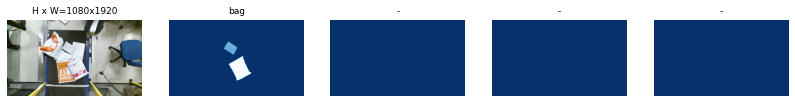

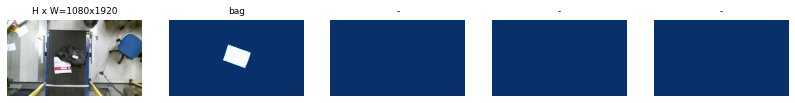

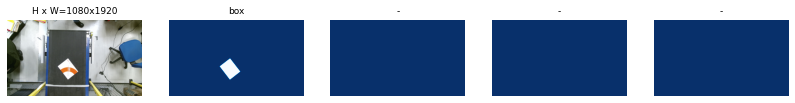

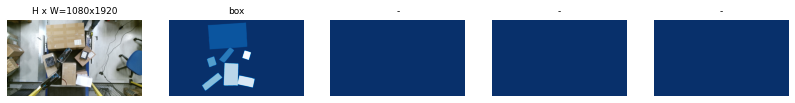

In [5]:
# Load and display random samples
image_ids = np.random.choice(dataset.image_ids, 4)
for image_id in image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names)

## Bounding Boxes

Rather than using bounding box coordinates provided by the source datasets, we compute the bounding boxes from masks instead. This allows us to handle bounding boxes consistently regardless of the source dataset, and it also makes it easier to resize, rotate, or crop images because we simply generate the bounding boxes from the updates masks rather than computing bounding box transformation for each type of image transformation.

image_id  906 /user/student.aau.dk/htra19/group660/tests/dataset_beumer_test/train/919.jpeg
image                    shape: (1080, 1920, 3)       min:    0.00000  max:  255.00000  uint8
mask                     shape: (1080, 1920, 1)       min:    0.00000  max:    1.00000  uint8
class_ids                shape: (1,)                  min:    1.00000  max:    1.00000  int32
bbox                     shape: (1, 4)                min:  222.00000  max: 1091.00000  int32


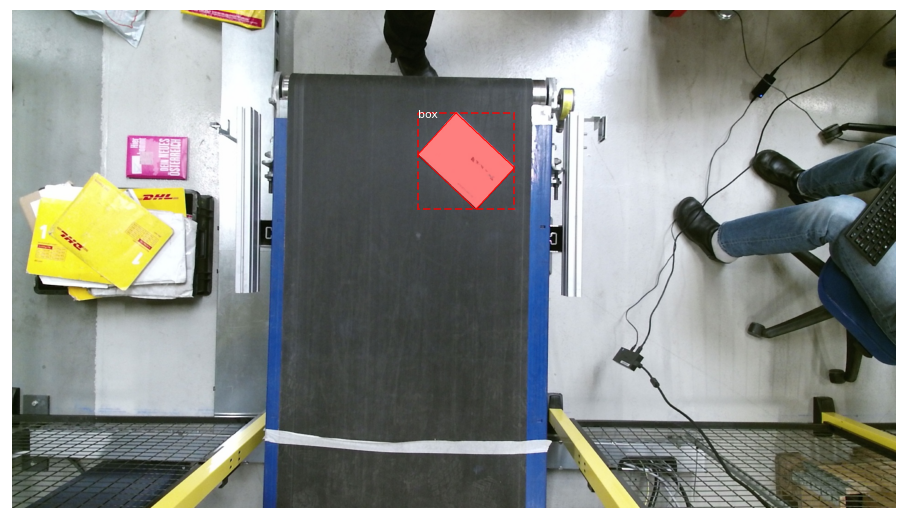

In [6]:
# Load random image and mask.
image_id = random.choice(dataset.image_ids)
image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)
# Compute Bounding box
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("image_id ", image_id, dataset.image_reference(image_id))
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

## Resize Images

To support multiple images per batch, images are resized to one size (1024x1024). Aspect ratio is preserved, though. If an image is not square, then zero padding is added at the top/bottom or right/left.

image_id:  71 /user/student.aau.dk/htra19/group660/tests/dataset_beumer_test/train/084.jpeg
Original shape:  (1080, 1920, 3)
image                    shape: (1920, 1920, 3)       min:    0.00000  max:  255.00000  uint8
mask                     shape: (1920, 1920, 1)       min:    0.00000  max:    1.00000  uint8
class_ids                shape: (1,)                  min:    1.00000  max:    1.00000  int32
bbox                     shape: (1, 4)                min:  725.00000  max: 1232.00000  int32


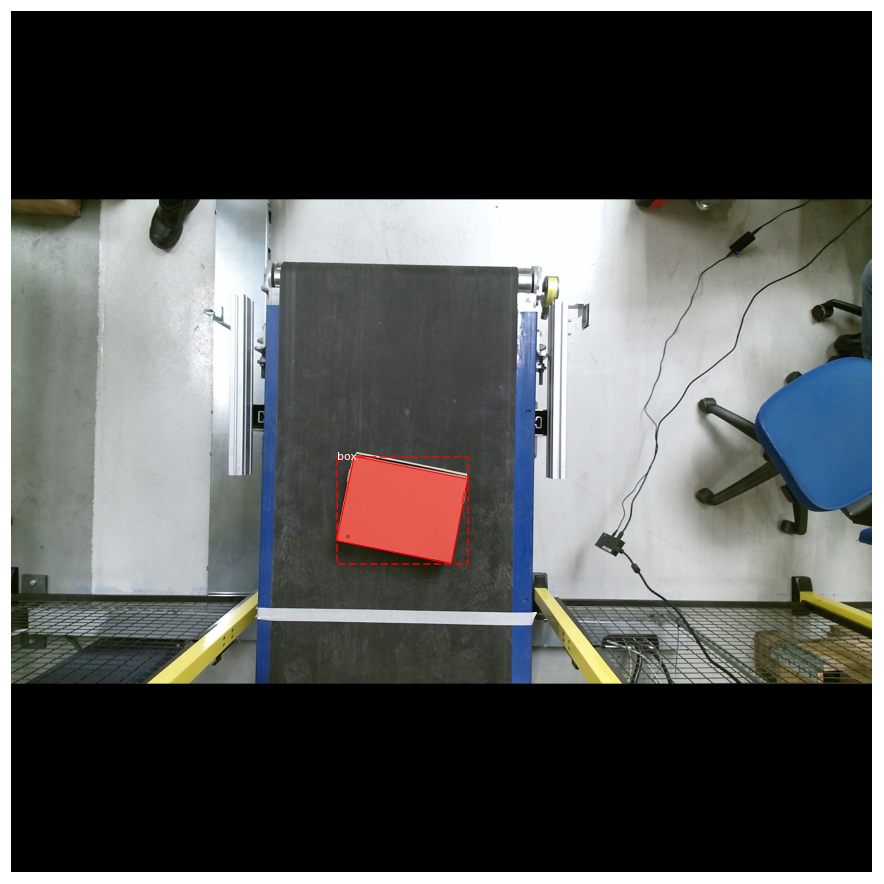

In [7]:
# Load random image and mask.
image_id = np.random.choice(dataset.image_ids, 1)[0]
image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)
original_shape = image.shape
# Resize
image, window, scale, padding, _ = utils.resize_image(
    image, 
    min_dim=config.IMAGE_MIN_DIM, 
    max_dim=config.IMAGE_MAX_DIM,
    mode=config.IMAGE_RESIZE_MODE)
mask = utils.resize_mask(mask, scale, padding)
# Compute Bounding box
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("image_id: ", image_id, dataset.image_reference(image_id))
print("Original shape: ", original_shape)
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

## Mini Masks

Instance binary masks can get large when training with high resolution images. For example, if training with 1024x1024 image then the mask of a single instance requires 1MB of memory (Numpy uses bytes for boolean values). If an image has 100 instances then that's 100MB for the masks alone. 

To improve training speed, we optimize masks by:
* We store mask pixels that are inside the object bounding box, rather than a mask of the full image. Most objects are small compared to the image size, so we save space by not storing a lot of zeros around the object.
* We resize the mask to a smaller size (e.g. 56x56). For objects that are larger than the selected size we lose a bit of accuracy. But most object annotations are not very accuracy to begin with, so this loss is negligable for most practical purposes. Thie size of the mini_mask can be set in the config class.

To visualize the effect of mask resizing, and to verify the code correctness, we visualize some examples.

image                    shape: (1920, 1920, 3)       min:    0.00000  max:  255.00000  uint8
image_meta               shape: (15,)                 min:    0.00000  max: 1920.00000  int64
class_ids                shape: (5,)                  min:    1.00000  max:    1.00000  int32
bbox                     shape: (5, 4)                min:  583.00000  max: 1306.00000  int32
mask                     shape: (1920, 1920, 5)       min:    0.00000  max:    1.00000  uint8


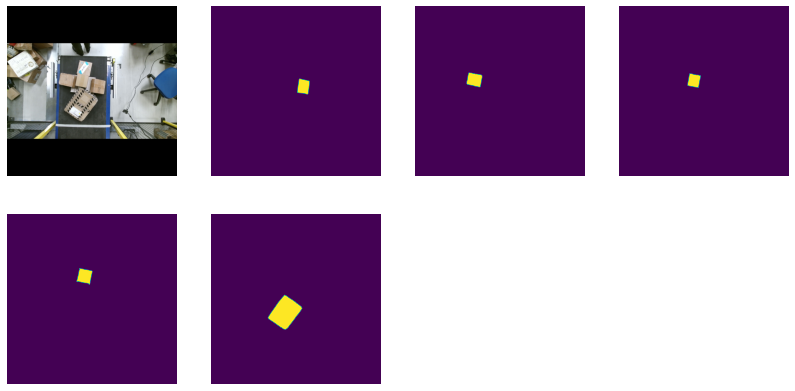

In [8]:
image_id = np.random.choice(dataset.image_ids, 1)[0]
image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(
    dataset, config, image_id, use_mini_mask=False)

log("image", image)
log("image_meta", image_meta)
log("class_ids", class_ids)
log("bbox", bbox)
log("mask", mask)

display_images([image]+[mask[:,:,i] for i in range(min(mask.shape[-1], 7))])

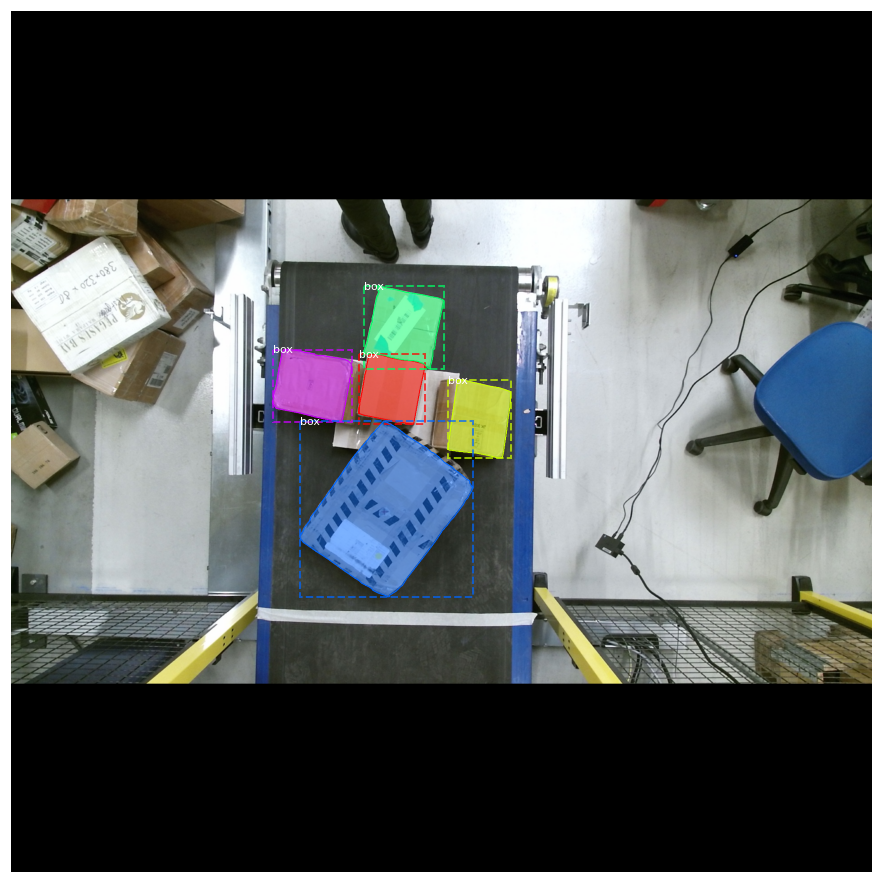

In [9]:
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

mask                     shape: (56, 56, 5)           min:    0.00000  max:    1.00000  bool


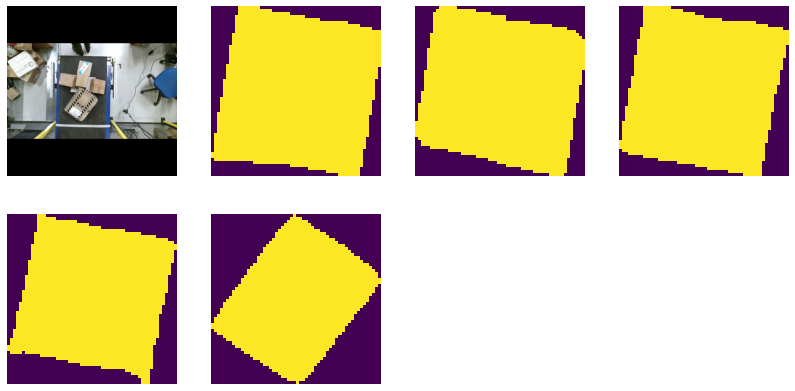

In [10]:
# Add augmentation and mask resizing.
image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(
    dataset, config, image_id, augment=True, use_mini_mask=True)
log("mask", mask)
display_images([image]+[mask[:,:,i] for i in range(min(mask.shape[-1], 7))])

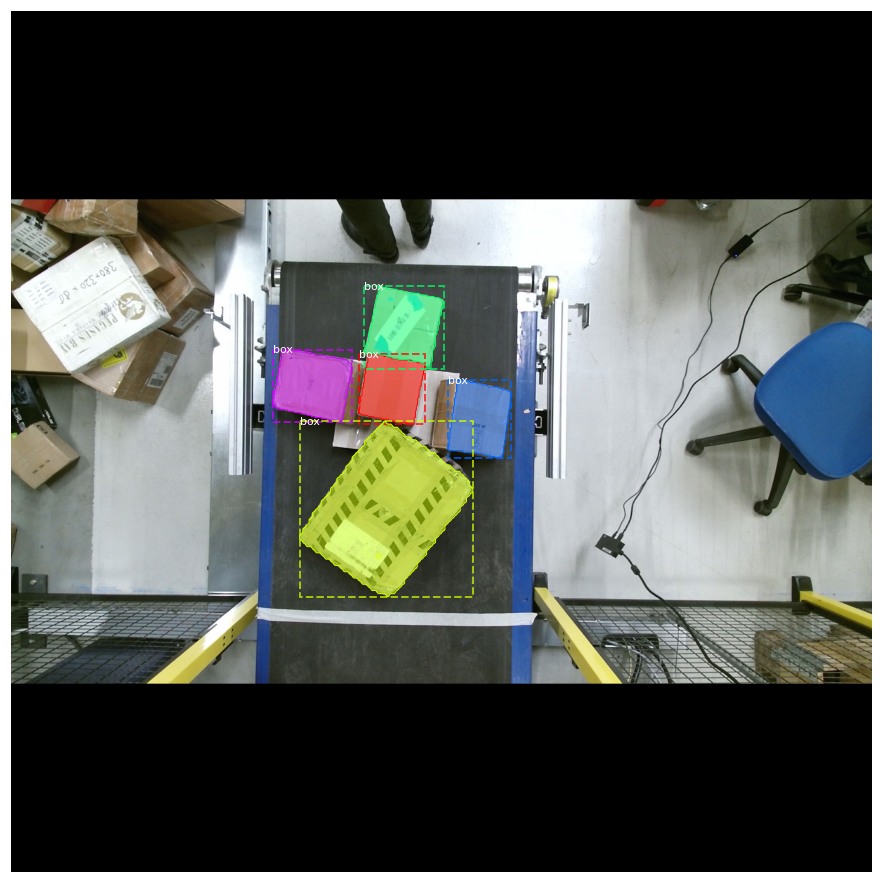

In [11]:
mask = utils.expand_mask(bbox, mask, image.shape)
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

## Anchors

The order of anchors is important. Use the same order in training and prediction phases. And it must match the order of the convolution execution.

For an FPN network, the anchors must be ordered in a way that makes it easy to match anchors to the output of the convolution layers that predict anchor scores and shifts. 
* Sort by pyramid level first. All anchors of the first level, then all of the second and so on. This makes it easier to separate anchors by level.
* Within each level, sort anchors by feature map processing sequence. Typically, a convolution layer processes a feature map starting from top-left and moving right row by row. 
* For each feature map cell, pick any sorting order for the anchors of different ratios. Here we match the order of ratios passed to the function.

**Anchor Stride:**
In the FPN architecture, feature maps at the first few layers are high resolution. For example, if the input image is 1024x1024 then the feature map of the first layer is 256x256, which generates about 200K anchors (256x256x3). These anchors are 32x32 pixels and their stride relative to image pixels is 4 pixels, so there is a lot of overlap. We can reduce the load significantly if we generate anchors for every other cell in the feature map. A stride of 2 will cut the number of anchors by 4, for example. 

In this implementation we use an anchor stride of 2, which is different from the paper.

In [12]:
# Generate Anchors
backbone_shapes = modellib.compute_backbone_shapes(config, config.IMAGE_SHAPE)
anchors = utils.generate_pyramid_anchors(config.RPN_ANCHOR_SCALES, 
                                          config.RPN_ANCHOR_RATIOS,
                                          backbone_shapes,
                                          config.BACKBONE_STRIDES, 
                                          config.RPN_ANCHOR_STRIDE)

# Print summary of anchors
num_levels = len(backbone_shapes)
anchors_per_cell = len(config.RPN_ANCHOR_RATIOS)
print("Count: ", anchors.shape[0])
print("Scales: ", config.RPN_ANCHOR_SCALES)
print("ratios: ", config.RPN_ANCHOR_RATIOS)
print("Anchors per Cell: ", anchors_per_cell)
print("Levels: ", num_levels)
anchors_per_level = []
for l in range(num_levels):
    num_cells = backbone_shapes[l][0] * backbone_shapes[l][1]
    anchors_per_level.append(anchors_per_cell * num_cells // config.RPN_ANCHOR_STRIDE**2)
    print("Anchors in Level {}: {}".format(l, anchors_per_level[l]))

Count:  920700
Scales:  (32, 64, 128, 256, 512)
ratios:  [0.5, 1, 2]
Anchors per Cell:  3
Levels:  5
Anchors in Level 0: 691200
Anchors in Level 1: 172800
Anchors in Level 2: 43200
Anchors in Level 3: 10800
Anchors in Level 4: 2700


Visualize anchors of one cell at the center of the feature map of a specific level.

Level 0. Anchors: 691200  Feature map Shape: [480 480]
Level 1. Anchors: 172800  Feature map Shape: [240 240]
Level 2. Anchors:  43200  Feature map Shape: [120 120]
Level 3. Anchors:  10800  Feature map Shape: [60 60]
Level 4. Anchors:   2700  Feature map Shape: [30 30]


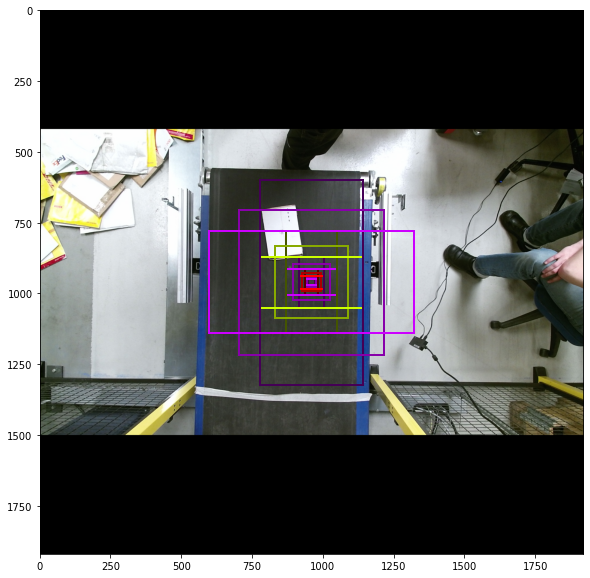

In [13]:
## Visualize anchors of one cell at the center of the feature map of a specific level

# Load and draw random image
image_id = np.random.choice(dataset.image_ids, 1)[0]
image, image_meta, _, _, _ = modellib.load_image_gt(dataset, config, image_id)
fig, ax = plt.subplots(1, figsize=(10, 10))
ax.imshow(image)
levels = len(backbone_shapes)

for level in range(levels):
    colors = visualize.random_colors(levels)
    # Compute the index of the anchors at the center of the image
    level_start = sum(anchors_per_level[:level]) # sum of anchors of previous levels
    level_anchors = anchors[level_start:level_start+anchors_per_level[level]]
    print("Level {}. Anchors: {:6}  Feature map Shape: {}".format(level, level_anchors.shape[0], 
                                                                  backbone_shapes[level]))
    center_cell = backbone_shapes[level] // 2
    center_cell_index = (center_cell[0] * backbone_shapes[level][1] + center_cell[1])
    level_center = center_cell_index * anchors_per_cell 
    center_anchor = anchors_per_cell * (
        (center_cell[0] * backbone_shapes[level][1] / config.RPN_ANCHOR_STRIDE**2) \
        + center_cell[1] / config.RPN_ANCHOR_STRIDE)
    level_center = int(center_anchor)

    # Draw anchors. Brightness show the order in the array, dark to bright.
    for i, rect in enumerate(level_anchors[level_center:level_center+anchors_per_cell]):
        y1, x1, y2, x2 = rect
        p = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, facecolor='none',
                              edgecolor=(i+1)*np.array(colors[level]) / anchors_per_cell)
        ax.add_patch(p)


## Data Generator


In [14]:
# Create data generator
random_rois = 2000
g = modellib.data_generator(
    dataset, config, shuffle=True, random_rois=random_rois, 
    batch_size=4,
    detection_targets=True)

In [15]:
# Uncomment to run the generator through a lot of images
# to catch rare errors
# for i in range(1000):
#     print(i)
#     _, _ = next(g)

In [16]:
# Get Next Image
if random_rois:
    [normalized_images, image_meta, rpn_match, rpn_bbox, gt_class_ids, gt_boxes, gt_masks, rpn_rois, rois], \
    [mrcnn_class_ids, mrcnn_bbox, mrcnn_mask] = next(g)
    
    log("rois", rois)
    log("mrcnn_class_ids", mrcnn_class_ids)
    log("mrcnn_bbox", mrcnn_bbox)
    log("mrcnn_mask", mrcnn_mask)
else:
    [normalized_images, image_meta, rpn_match, rpn_bbox, gt_boxes, gt_masks], _ = next(g)
    
log("gt_class_ids", gt_class_ids)
log("gt_boxes", gt_boxes)
log("gt_masks", gt_masks)
log("rpn_match", rpn_match, )
log("rpn_bbox", rpn_bbox)
image_id = modellib.parse_image_meta(image_meta)["image_id"][0]
print("image_id: ", image_id, dataset.image_reference(image_id))

# Remove the last dim in mrcnn_class_ids. It's only added
# to satisfy Keras restriction on target shape.
mrcnn_class_ids = mrcnn_class_ids[:,:,0]

rois                     shape: (4, 1024, 4)          min:    3.00000  max: 1919.00000  int32
mrcnn_class_ids          shape: (4, 1024, 1)          min:    0.00000  max:    2.00000  int32
mrcnn_bbox               shape: (4, 1024, 3, 4)       min:   -3.22730  max:    3.03774  float32
mrcnn_mask               shape: (4, 1024, 28, 28, 3)  min:    0.00000  max:    1.00000  float32
gt_class_ids             shape: (4, 150)              min:    0.00000  max:    2.00000  int32
gt_boxes                 shape: (4, 150, 4)           min:    0.00000  max: 1323.00000  int32
gt_masks                 shape: (4, 56, 56, 150)      min:    0.00000  max:    1.00000  bool
rpn_match                shape: (4, 920700, 1)        min:   -1.00000  max:    1.00000  int32
rpn_bbox                 shape: (4, 256, 4)           min:   -1.34809  max:    1.60156  float64
image_id:  424 /user/student.aau.dk/htra19/group660/tests/dataset_beumer_test/train/1059.jpeg


anchors                  shape: (920700, 4)           min: -362.03867  max: 2218.03867  float64
refined_anchors          shape: (4, 4)                min:  823.00000  max: 1323.00000  float32
Positive anchors: 4
Negative anchors: 252
Neutral anchors: 920444
BG                     : 998
box                    : 26


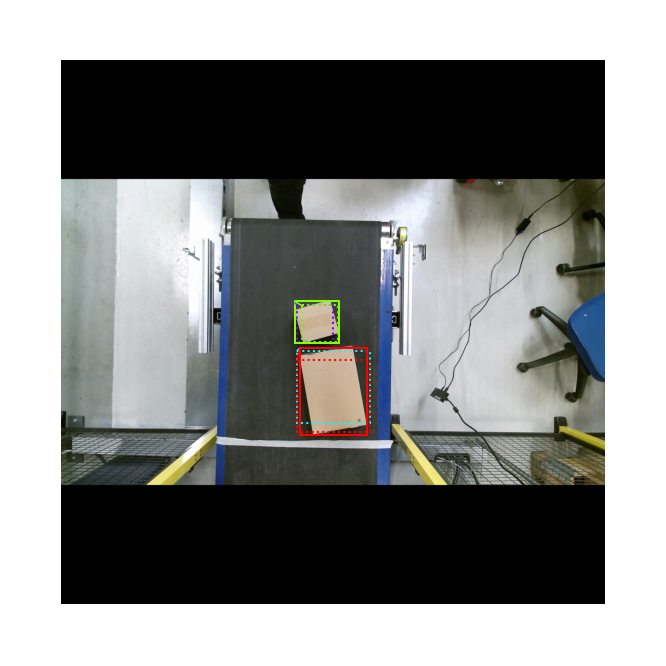

In [17]:
b = 0

# Restore original image (reverse normalization)
sample_image = modellib.unmold_image(normalized_images[b], config)

# Compute anchor shifts.
indices = np.where(rpn_match[b] == 1)[0]
refined_anchors = utils.apply_box_deltas(anchors[indices], rpn_bbox[b, :len(indices)] * config.RPN_BBOX_STD_DEV)
log("anchors", anchors)
log("refined_anchors", refined_anchors)

# Get list of positive anchors
positive_anchor_ids = np.where(rpn_match[b] == 1)[0]
print("Positive anchors: {}".format(len(positive_anchor_ids)))
negative_anchor_ids = np.where(rpn_match[b] == -1)[0]
print("Negative anchors: {}".format(len(negative_anchor_ids)))
neutral_anchor_ids = np.where(rpn_match[b] == 0)[0]
print("Neutral anchors: {}".format(len(neutral_anchor_ids)))

# ROI breakdown by class
for c, n in zip(dataset.class_names, np.bincount(mrcnn_class_ids[b].flatten())):
    if n:
        print("{:23}: {}".format(c[:20], n))

# Show positive anchors
visualize.draw_boxes(sample_image, boxes=anchors[positive_anchor_ids], 
                     refined_boxes=refined_anchors)

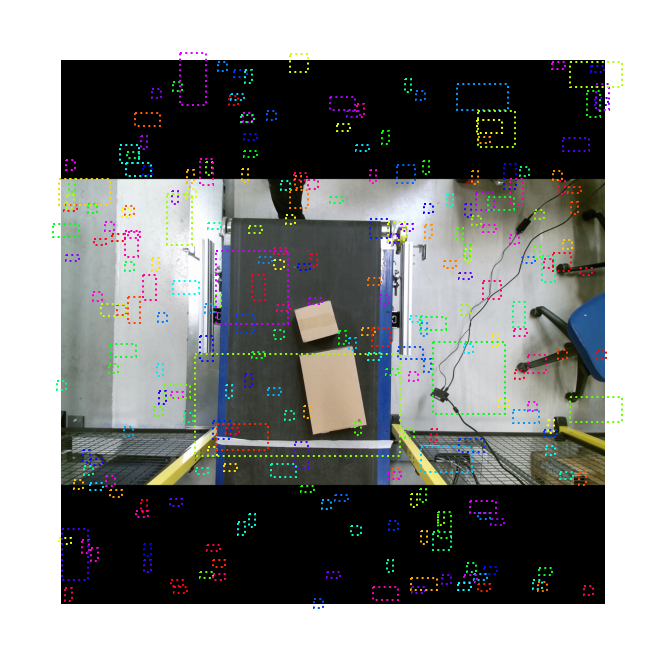

In [18]:
# Show negative anchors
visualize.draw_boxes(sample_image, boxes=anchors[negative_anchor_ids])

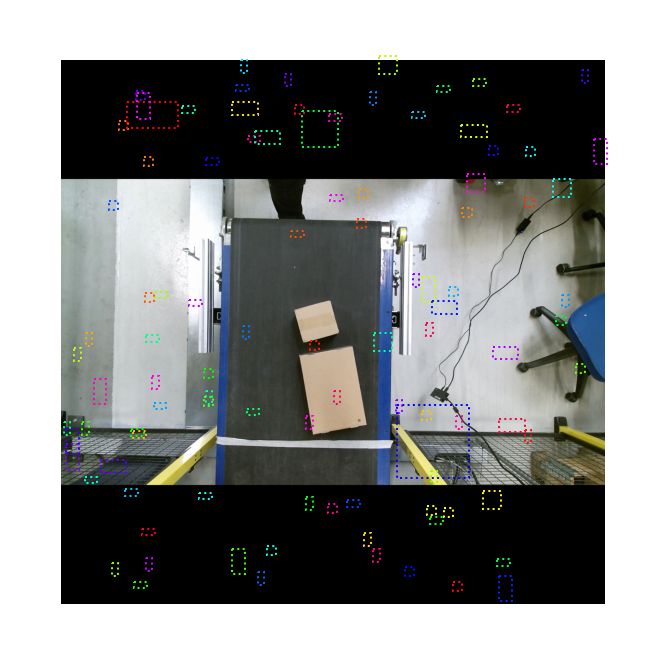

In [19]:
# Show neutral anchors. They don't contribute to training.
visualize.draw_boxes(sample_image, boxes=anchors[np.random.choice(neutral_anchor_ids, 100)])

## ROIs

Positive ROIs:  26
Negative ROIs:  998
Positive Ratio: 0.03
Unique ROIs: 1024 out of 1024


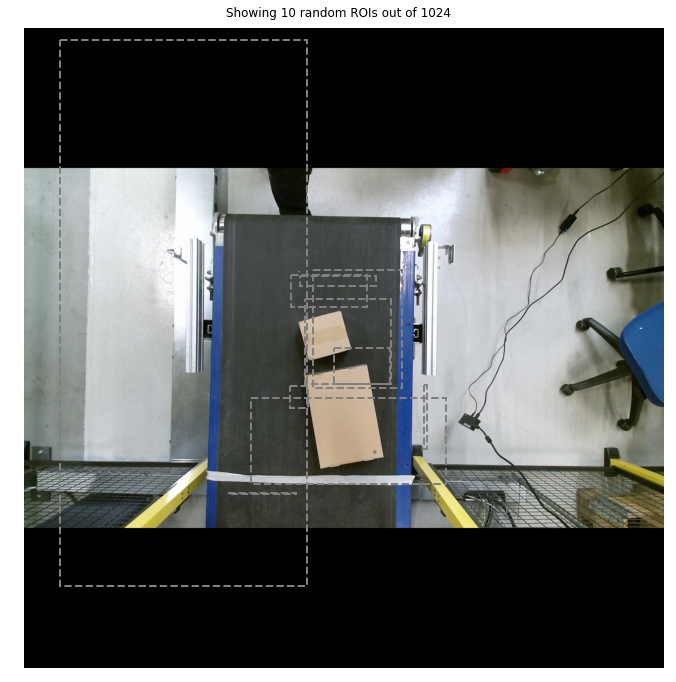

In [20]:
if random_rois:
    # Class aware bboxes
    bbox_specific = mrcnn_bbox[b, np.arange(mrcnn_bbox.shape[1]), mrcnn_class_ids[b], :]

    # Refined ROIs
    refined_rois = utils.apply_box_deltas(rois[b].astype(np.float32), bbox_specific[:,:4] * config.BBOX_STD_DEV)

    # Class aware masks
    mask_specific = mrcnn_mask[b, np.arange(mrcnn_mask.shape[1]), :, :, mrcnn_class_ids[b]]

    visualize.draw_rois(sample_image, rois[b], refined_rois, mask_specific, mrcnn_class_ids[b], dataset.class_names)
    
    # Any repeated ROIs?
    rows = np.ascontiguousarray(rois[b]).view(np.dtype((np.void, rois.dtype.itemsize * rois.shape[-1])))
    _, idx = np.unique(rows, return_index=True)
    print("Unique ROIs: {} out of {}".format(len(idx), rois.shape[1]))

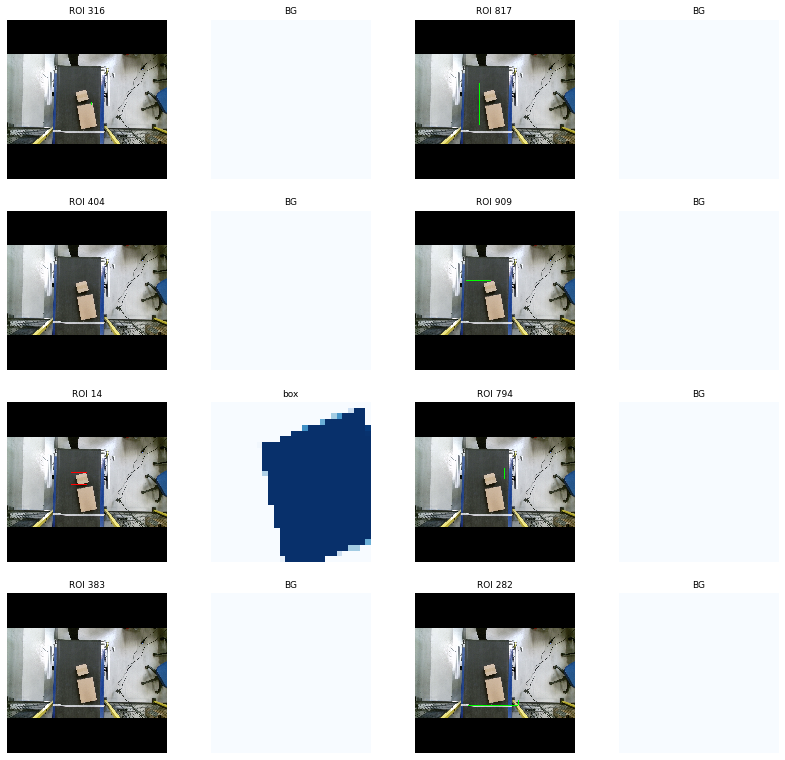

In [21]:
if random_rois:
    # Dispalay ROIs and corresponding masks and bounding boxes
    ids = random.sample(range(rois.shape[1]), 8)

    images = []
    titles = []
    for i in ids:
        image = visualize.draw_box(sample_image.copy(), rois[b,i,:4].astype(np.int32), [255, 0, 0])
        image = visualize.draw_box(image, refined_rois[i].astype(np.int64), [0, 255, 0])
        images.append(image)
        titles.append("ROI {}".format(i))
        images.append(mask_specific[i] * 255)
        titles.append(dataset.class_names[mrcnn_class_ids[b,i]][:20])

    display_images(images, titles, cols=4, cmap="Blues", interpolation="none")

In [22]:
# Check ratio of positive ROIs in a set of images.
if random_rois:
    limit = 10
    temp_g = modellib.data_generator(
        dataset, config, shuffle=True, random_rois=10000, 
        batch_size=1, detection_targets=True)
    total = 0
    for i in range(limit):
        _, [ids, _, _] = next(temp_g)
        positive_rois = np.sum(ids[0] > 0)
        total += positive_rois
        print("{:5} {:5.2f}".format(positive_rois, positive_rois/ids.shape[1]))
    print("Average percent: {:.2f}".format(total/(limit*ids.shape[1])))

  119  0.12
  107  0.10
   94  0.09
  101  0.10
   98  0.10
  111  0.11
   96  0.09
  103  0.10
  104  0.10
  150  0.15
Average percent: 0.11
